In [26]:
import datetime
print(datetime.datetime.now())
today = datetime.datetime.now().strftime('%d/%m/%Y')

2025-10-16 04:20:19.795960


In [27]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlt

In [28]:
df = pd.read_csv('melb_data.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [29]:
df.tail()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0
13579,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1.0,1.0,362.0,112.0,1920.0,NaN,-37.81188,144.88449,Western Metropolitan,6543.0


In [30]:
df.isna().sum().sum()

np.int64(13256)

In [31]:
df.isna().sum().sort_values(ascending=False)

BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Car                62
Suburb              0
Price               0
Type                0
Rooms               0
Address             0
Distance            0
Method              0
Date                0
SellerG             0
Bathroom            0
Bedroom2            0
Postcode            0
Landsize            0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [32]:
TYPE, SUBURB, COUNCIL, REGION = "Type", "Suburb", "CouncilArea", "Regionname"

for c in [TYPE, SUBURB, COUNCIL, REGION]:
    if c in df.columns:
        df[c] = (df[c].astype("string")
                       .str.strip()
                       .str.replace(r"\s+", " ", regex=True))
if TYPE in df.columns:
    df[TYPE] = df[TYPE].str.lower()   

pairs = df.dropna(subset=[TYPE, SUBURB, COUNCIL])[[TYPE, SUBURB, COUNCIL]].copy()

dup_check = (pairs.drop_duplicates()
                   .groupby([TYPE, SUBURB])[COUNCIL].nunique()
                   .reset_index(name="n_unique"))
conflicts = dup_check[dup_check["n_unique"] > 1]
if not conflicts.empty:
    print("Conflicts found: (Type, Suburb) → multiple CouncilAreas (showing first 20 rows):")
    print(pairs.merge(conflicts[[TYPE, SUBURB]], on=[TYPE, SUBURB], how="inner")
               .drop_duplicates()
               .head(20)
               .to_string(index=False))

ts_map = (
    pairs.groupby([TYPE, SUBURB], dropna=False)[COUNCIL]
         .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else pd.NA)
         .reset_index()
         .rename(columns={COUNCIL: "_mode"})
)

miss_mask = df[COUNCIL].isna() & df[TYPE].notna() & df[SUBURB].notna()
before = int(miss_mask.sum())

if before > 0:
    merged = df.loc[miss_mask, [TYPE, SUBURB]].merge(ts_map, on=[TYPE, SUBURB], how="left")["_mode"]
    has = merged.notna().to_numpy()
    idx = df.loc[miss_mask].index
    df.loc[idx[has], COUNCIL] = merged[has].to_numpy()

after = int(df[COUNCIL].isna().sum())
print(f"(Type, Suburb) filled {before - (after if before > 0 else 0)} rows; remaining missing: {after}")

df[COUNCIL] = df[COUNCIL].astype("string").str.strip().replace({"": pd.NA}).astype("category")
print(f"Done. Remaining missing in {COUNCIL}: {int(df[COUNCIL].isna().sum())}")

Conflicts found: (Type, Suburb) → multiple CouncilAreas (showing first 20 rows):
Type        Suburb  CouncilArea
   h    Alphington      Darebin
   h    Alphington        Yarra
   t    Alphington      Darebin
   t    Alphington        Yarra
   h Brighton East      Bayside
   h Brighton East    Glen Eira
   h       Burwood   Whitehorse
   h       Burwood       Monash
   u       Burwood   Whitehorse
   u       Burwood       Monash
   t       Burwood   Whitehorse
   t       Burwood       Monash
   h  Coburg North     Moreland
   h  Coburg North      Darebin
   u        Elwood Port Phillip
   u        Elwood    Glen Eira
   u     Fairfield      Darebin
   u     Fairfield        Yarra
   h Fitzroy North        Yarra
   h Fitzroy North     Moreland
(Type, Suburb) filled 1348 rows; remaining missing: 21
Done. Remaining missing in CouncilArea: 21


In [33]:
df["CouncilArea"].isna().sum()

np.int64(21)

In [34]:
SUBURB, COUNCIL, REGION = "Suburb", "CouncilArea", "Regionname"

def fill_with_suburb_mode(df):
    miss = df[COUNCIL].isna() & df[SUBURB].notna()
    before = int(miss.sum())
    if before == 0:
        print("[Suburb mode] nothing to fill.")
        return 0
    sub_map = (
        df.dropna(subset=[SUBURB, COUNCIL])
          .groupby(SUBURB, dropna=False)[COUNCIL]
          .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else pd.NA)
    )
    df.loc[miss, COUNCIL] = df.loc[miss, SUBURB].map(sub_map)
    after = int(df[COUNCIL].isna().sum())
    filled = before - (after if before>0 else 0)
    print(f"[Suburb mode] filled {filled} | remaining {after}")
    return filled

def fill_with_region_mode(df):
    if REGION not in df.columns:
        print("[Region mode] Regionname not found.")
        return 0
    miss = df[COUNCIL].isna() & df[REGION].notna()
    before = int(miss.sum())
    if before == 0:
        print("[Region mode] nothing to fill.")
        return 0
    reg_map = (
        df.dropna(subset=[REGION, COUNCIL])
          .groupby(REGION, dropna=False)[COUNCIL]
          .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else pd.NA)
    )
    df.loc[miss, COUNCIL] = df.loc[miss, REGION].map(reg_map)
    after = int(df[COUNCIL].isna().sum())
    filled = before - (after if before>0 else 0)
    print(f"[Region mode] filled {filled} | remaining {after}")
    return filled

def fill_with_global_mode(df):
    miss = df[COUNCIL].isna()
    before = int(miss.sum())
    if before == 0:
        print("[Global mode] nothing to fill.")
        return 0
    gm = df[COUNCIL].mode(dropna=True)
    fallback = gm.iat[0] if not gm.empty else "Unknown"
    df.loc[miss, COUNCIL] = fallback
    print(f"[Global mode] filled {before} with '{fallback}' | remaining 0")
    return before

print(f"Missing before: {int(df[COUNCIL].isna().sum())}")
fill_with_suburb_mode(df)   
fill_with_region_mode(df)   
fill_with_global_mode(df)   

df[COUNCIL] = df[COUNCIL].astype("string").str.strip().replace({"": pd.NA}).astype("category")
print(f"Done. Remaining missing in {COUNCIL}: {int(df[COUNCIL].isna().sum())}")

Missing before: 21
[Suburb mode] filled 14 | remaining 7
[Region mode] filled 7 | remaining 0
[Global mode] nothing to fill.
Done. Remaining missing in CouncilArea: 0


In [35]:
df['CouncilArea']

0              Yarra
1              Yarra
2              Yarra
3              Yarra
4              Yarra
            ...     
13575         Monash
13576    Hobsons Bay
13577    Hobsons Bay
13578    Hobsons Bay
13579    Maribyrnong
Name: CouncilArea, Length: 13580, dtype: category
Categories (33, string): [Banyule, Bayside, Boroondara, Brimbank, ..., Whittlesea, Wyndham, Yarra, Yarra Ranges]

In [36]:
TYPE, CAR = "Type", "Car"

df[TYPE] = df[TYPE].astype("string").str.strip().str.lower()   
df[CAR]  = pd.to_numeric(df[CAR], errors="coerce")


df.loc[df[CAR] < 0, CAR] = np.nan          
df[CAR] = df[CAR].clip(upper=6)            

type_mode = (
    df.dropna(subset=[CAR])
      .groupby(TYPE, dropna=False)[CAR]
      .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else np.nan)
)

missing_before = int(df[CAR].isna().sum())

for t in ["h", "u"]:
    if t in type_mode.index and pd.notna(type_mode.loc[t]):
        mask = df[CAR].isna() & (df[TYPE] == t)
        fill_val = type_mode.loc[t]
        df.loc[mask, CAR] = fill_val
        print(f"[{t}] used mode={int(fill_val)} to fill {int(mask.sum())} rows")

missing_after = int(df[CAR].isna().sum())
print(f"Filled {missing_before - missing_after} / {missing_before} missing Car values; remaining: {missing_after}")

df[CAR] = df[CAR].round().astype("Int64")
print("Car value counts after fill:")
print(df[CAR].value_counts(dropna=False).sort_index())

USE_TYPE_ROOMS_BACKUP = False
if USE_TYPE_ROOMS_BACKUP and "Rooms" in df.columns and missing_after > 0:
    rm = (df.dropna(subset=[CAR, "Rooms"])
            .groupby([TYPE, "Rooms"], dropna=False)[CAR]
            .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else np.nan)
            .reset_index().rename(columns={CAR: "_mode"}))

    miss_idx = df.index[df[CAR].isna() & df[TYPE].notna() & df["Rooms"].notna()]
    merged = df.loc[miss_idx, [TYPE, "Rooms"]].merge(rm, on=[TYPE, "Rooms"], how="left")["_mode"]
    has = merged.notna()
    df.loc[miss_idx[has], CAR] = merged[has].values

    df[CAR] = df[CAR].round().astype("Int64")
    print(f"(Type, Rooms) backup filled {int(has.sum())}; remaining: {int(df[CAR].isna().sum())}")

[h] used mode=2 to fill 60 rows
[u] used mode=1 to fill 2 rows
Filled 62 / 62 missing Car values; remaining: 0
Car value counts after fill:
Car
0    1026
1    5511
2    5651
3     748
4     506
5      63
6      75
Name: count, dtype: Int64


In [37]:
df.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [38]:
df.head(30)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
5,Abbotsford,129 Charles St,2,h,941000.0,S,Jellis,7/05/2016,2.5,3067.0,...,1.0,0,181.0,NaN,NaN,Yarra,-37.8041,144.9953,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,1,0.0,NaN,NaN,Yarra,-37.8008,144.9973,Northern Metropolitan,4019.0
9,Abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,2,220.0,75.0,1900.0,Yarra,-37.8010,144.9989,Northern Metropolitan,4019.0


In [39]:
df.to_csv("melb_data_final.csv", index=False)

In [40]:
print("To which period of time the data refers to?")

To which period of time the data refers to?


In [41]:
df['Date'] = pd.to_datetime(df['Date'].astype(str).str.strip(),
                              dayfirst=True, errors='raise')
dmin = df['Date'].min()
dmax = df['Date'].max()

print("Answer:")
print(dmin.date())
print(dmax.date())

Answer:
2016-01-28
2017-09-23


In [42]:
report = """I. Business Context & Objectives
Business Context:
Melbourne residential property transactions dataset with fields: Date, Regionname, Suburb, Price, Rooms, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Type, Method, SellerG.

Objectives:
Leverage historical transactions and property attributes to support key decisions in pricing, site selection, listing strategy (e.g., auction vs. private sale), inventory mix optimization, and risk monitoring.
"""
print(report)

I. Business Context & Objectives
Business Context:
Melbourne residential property transactions dataset with fields: Date, Regionname, Suburb, Price, Rooms, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Type, Method, SellerG.

Objectives:
Leverage historical transactions and property attributes to support key decisions in pricing, site selection, listing strategy (e.g., auction vs. private sale), inventory mix optimization, and risk monitoring.



In [43]:
report = """II. Stakeholders
Buyers: Identify areas/suburbs with strong value-for-money and growth potential.
Agencies: Set listing prices, choose sale method (Method), and plan product mix and release cadence.
"""
print(report)

II. Stakeholders
Buyers: Identify areas/suburbs with strong value-for-money and growth potential.
Agencies: Set listing prices, choose sale method (Method), and plan product mix and release cadence.



In [44]:
report= """ III. Use Case

We organize use cases along two complementary lenses:

Branch A – Price ↔ Features: How each feature associates with Price.

Branch B – Market ↔ Features: How each feature associates with Market.
"""
print(report)

 III. Use Case

We organize use cases along two complementary lenses:

Branch A – Price ↔ Features: How each feature associates with Price.

Branch B – Market ↔ Features: How each feature associates with Market.



In [45]:
report= """Branch A — Price ↔ Features

UC1.a — Suburb vs Price
Question: Which suburbs would most effect price(most or least expensive)?
"""
print(report)

Branch A — Price ↔ Features

UC1.a — Suburb vs Price
Question: Which suburbs would most effect price(most or least expensive)?



In [46]:
data=df.copy()

In [47]:
g = (
    df.groupby("Suburb")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]

MIN_N = 50
g_stable = g[g["count"] >= MIN_N].copy()

qs = g_stable["median"].quantile([0.2, 0.4, 0.6, 0.8]).values
def bucket(v):
    if v <= qs[0]: return "Very Low"
    elif v <= qs[1]: return "Low"
    elif v <= qs[2]: return "Medium"
    elif v <= qs[3]: return "High"
    else: return "Very High"

g_stable["Affordability"] = g_stable["median"].apply(bucket)

top10_exp = g_stable.sort_values("median", ascending=False).head(10)
top10_aff = g_stable.sort_values("median", ascending=True).head(10)


print(f"Stable suburbs (n ≥ {MIN_N}): {len(g_stable)}")
display(g_stable.sort_values("median", ascending=False)
        .rename(columns={"median":"MedianPrice"})[["Suburb","MedianPrice","IQR","count","Affordability"]]
        .head(20))

Stable suburbs (n ≥ 50): 92


,Suburb,MedianPrice,IQR,count,Affordability
4,Albert Park,1900000.0,655000.0,69,Very High
60,Canterbury,1890000.0,1540500.0,54,Very High
21,Balwyn,1850000.0,1368500.0,107,Very High
41,Brighton,1773500.0,1264375.0,186,Very High
22,Balwyn North,1739000.0,565000.0,171,Very High
58,Camberwell,1695000.0,1484000.0,132,Very High
136,Glen Iris,1660000.0,1114750.0,195,Very High
13,Ashburton,1658500.0,426875.0,60,Very High
273,Surrey Hills,1650000.0,1201000.0,125,Very High
144,Hampton,1612500.0,1176625.0,130,Very High


In [48]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb", "Suburb")
PRICE  = cols.get("price",  "Price")

data = df[pd.to_numeric(df[PRICE], errors="coerce") > 0].copy()

g = (
    data.groupby(SUBURB)[PRICE]
        .agg(median="median",
             q1=lambda s: s.quantile(0.25),
             q3=lambda s: s.quantile(0.75),
             count="size")
        .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]

MIN_N = 50
g_stable = g[g["count"] >= MIN_N].copy()

top10_most_expensive   = g_stable.nlargest(10, "median")
top10_least_expensive  = g_stable.nsmallest(10, "median")
top10_most_affordable  = top10_least_expensive.copy()
top10_least_affordable = top10_most_expensive.copy()

print(f"Stable suburbs (n ≥ {MIN_N}): {len(g_stable)}")

print("\nTop 10 Most Expensive (by Median Price):")
display(top10_most_expensive[[SUBURB, "median", "IQR", "count"]]
        .rename(columns={SUBURB: "Suburb", "median": "MedianPrice"}))

print("\nTop 10 Least Expensive / Most Affordable:")
display(top10_least_expensive[[SUBURB, "median", "IQR", "count"]]
        .rename(columns={SUBURB: "Suburb", "median": "MedianPrice"}))

Stable suburbs (n ≥ 50): 92

Top 10 Most Expensive (by Median Price):


,Suburb,MedianPrice,IQR,count
4,Albert Park,1900000.0,655000.0,69
60,Canterbury,1890000.0,1540500.0,54
21,Balwyn,1850000.0,1368500.0,107
41,Brighton,1773500.0,1264375.0,186
22,Balwyn North,1739000.0,565000.0,171
58,Camberwell,1695000.0,1484000.0,132
136,Glen Iris,1660000.0,1114750.0,195
13,Ashburton,1658500.0,426875.0,60
273,Surrey Hills,1650000.0,1201000.0,125
144,Hampton,1612500.0,1176625.0,130



Top 10 Least Expensive / Most Affordable:


,Suburb,MedianPrice,IQR,count
298,Werribee,490000.0,116500.0,50
117,Epping,560500.0,144750.0,52
266,St Kilda,570000.0,540750.0,162
272,Sunshine West,591500.0,148750.0,86
153,Heidelberg West,648125.0,215000.0,76
271,Sunshine North,650000.0,117750.0,68
122,Fawkner,651250.0,172875.0,102
138,Glenroy,670000.0,246500.0,159
236,Reservoir,685000.0,340250.0,359
114,Elwood,687500.0,636000.0,131


In [49]:
import plotly.express as px

fig_exp = px.bar(
    top10_most_expensive.sort_values("median"),
    x="median", y=SUBURB, orientation="h",
    title="Top 10 Most Expensive Suburbs (Median Price)",
    hover_data={"median":":,.0f", "IQR":":,.0f", "count":True}
)
fig_exp.update_layout(xaxis_title="Median Price", yaxis_title="Suburb")
fig_exp.show()

fig_aff = px.bar(
    top10_least_expensive.sort_values("median"),
    x="median", y=SUBURB, orientation="h",
    title="Top 10 least Expensive Suburbs (Median Price)",
    hover_data={"median":":,.0f", "IQR":":,.0f", "count":True}
)
fig_aff.update_layout(xaxis_title="Median Price", yaxis_title="Suburb")
fig_aff.show()

In [50]:
exp_suburbs = set(top10_exp["Suburb"])
aff_suburbs = set(top10_aff["Suburb"])

df_exp = df[df["Suburb"].isin(exp_suburbs)].copy()
df_aff = df[df["Suburb"].isin(aff_suburbs)].copy()

def norm_type(s):
    x = str(s).strip().lower()
    x = x[0] if x else x
    return {"h":"House", "u":"Unit"}.get(x, "Other")

for d in (df_exp, df_aff):
    d["Kind"] = d["Type"].map(norm_type)


overall_exp = df_exp["Kind"].value_counts().rename_axis("Kind").rename("Count").reset_index()
overall_aff = df_aff["Kind"].value_counts().rename_axis("Kind").rename("Count").reset_index()

by_suburb_exp = (df_exp.groupby(["Suburb","Kind"]).size()
                        .rename("Count").reset_index()
                        .pivot(index="Suburb", columns="Kind", values="Count")
                        .fillna(0).astype(int).reset_index())

by_suburb_aff = (df_aff.groupby(["Suburb","Kind"]).size()
                        .rename("Count").reset_index()
                        .pivot(index="Suburb", columns="Kind", values="Count")
                        .fillna(0).astype(int).reset_index())

by_suburb_exp = by_suburb_exp.sort_values(by=["House","Unit"], ascending=False, na_position="last")
by_suburb_aff = by_suburb_aff.sort_values(by=["House","Unit"], ascending=False, na_position="last")

print("【Most expensive Top10 overall】")
print(overall_exp)
print("\n【Least expensive Top10 overall】")
print(overall_aff)

print("\n[Most Expensive Top 10] by suburb (rows = suburb, columns = House/Unit counts)")
display(by_suburb_exp)

print("\n[Most Affordable Top 10] by suburb (rows = suburb, columns = House/Unit counts)")
display(by_suburb_aff)

【Most expensive Top10 overall】
    Kind  Count
0  House    879
1   Unit    233
2  Other    117

【Least expensive Top10 overall】
    Kind  Count
0  House    838
1   Unit    333
2  Other     74

[Most Expensive Top 10] by suburb (rows = suburb, columns = House/Unit counts)


Kind,Suburb,House,Other,Unit
3,Balwyn North,146,12,13
7,Glen Iris,137,17,41
4,Brighton,111,26,49
9,Surrey Hills,88,7,30
5,Camberwell,87,12,33
8,Hampton,86,14,30
2,Balwyn,75,11,21
0,Albert Park,63,2,4
1,Ashburton,49,9,2
6,Canterbury,37,7,10



[Most Affordable Top 10] by suburb (rows = suburb, columns = House/Unit counts)


Kind,Suburb,House,Other,Unit
5,Reservoir,253,27,79
3,Glenroy,121,20,18
2,Fawkner,86,8,8
8,Sunshine West,79,4,3
4,Heidelberg West,71,1,4
7,Sunshine North,65,1,2
9,Werribee,48,0,2
1,Epping,46,1,5
6,St Kilda,39,3,120
0,Elwood,30,9,92


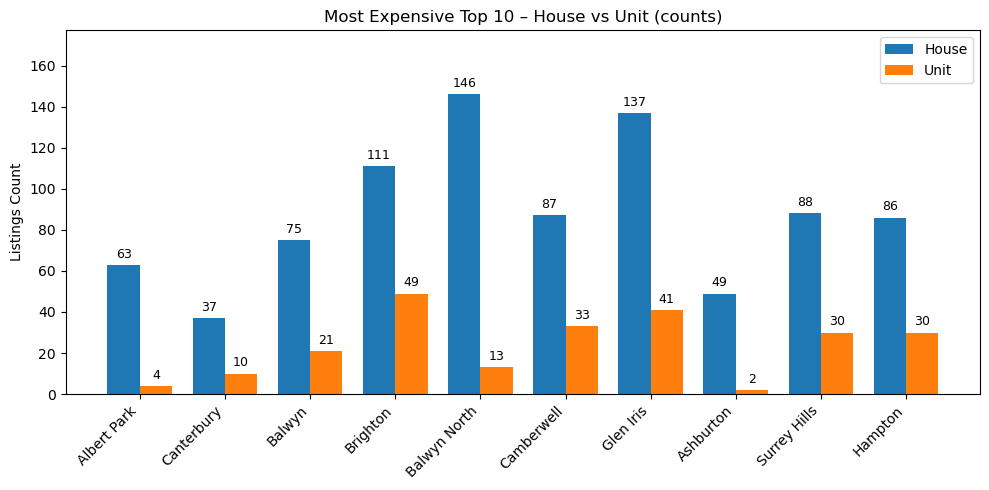

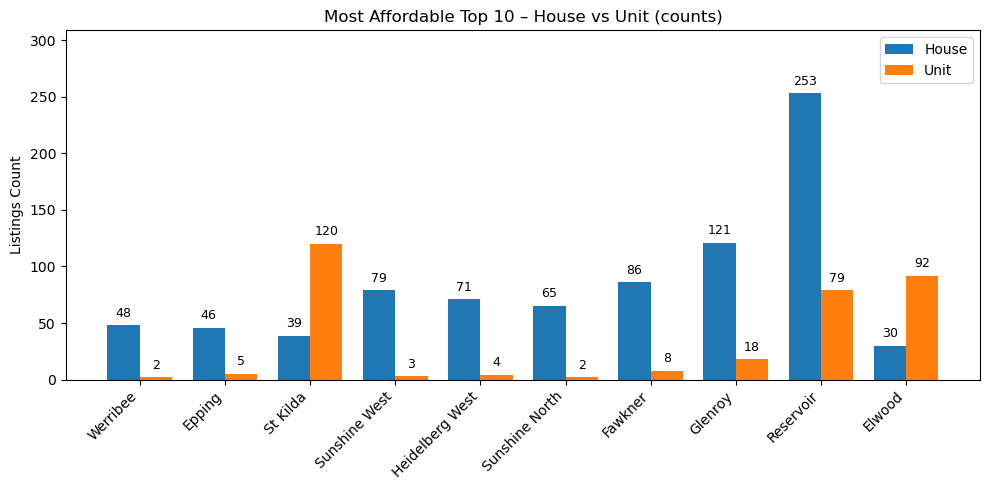


[Most Expensive Top 10] counts table


Kind,House,Unit
Suburb,,
Albert Park,63,4
Canterbury,37,10
Balwyn,75,21
Brighton,111,49
Balwyn North,146,13
Camberwell,87,33
Glen Iris,137,41
Ashburton,49,2
Surrey Hills,88,30



[Most Affordable Top 10] counts table


Kind,House,Unit
Suburb,,
Werribee,48,2
Epping,46,5
St Kilda,39,120
Sunshine West,79,3
Heidelberg West,71,4
Sunshine North,65,2
Fawkner,86,8
Glenroy,121,18
Reservoir,253,79


In [51]:
#Most Expensive Top 10 and Lesat expensive
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb", "Suburb")
PRICE  = cols.get("price",  "Price")
TYPE   = cols.get("type",   "Type")

data = df[[SUBURB, PRICE, TYPE]].copy()
data[PRICE] = pd.to_numeric(data[PRICE], errors="coerce")
data = data[data[PRICE] > 0].copy()

def norm_type(x):
    s = str(x).strip().lower()
    if not s: return "Other"
    if s[0] == "h": return "House"
    if s[0] == "u": return "Unit"
    return "Other"

data["Kind"] = data[TYPE].map(norm_type)

median_by_suburb = (data.groupby(SUBURB)[PRICE]
                        .median()
                        .rename("Median"))
total_counts = data.groupby(SUBURB).size().rename("TotalCount")

g = pd.concat([median_by_suburb, total_counts], axis=1)

MIN_N = 50  
g_stable = g[g["TotalCount"] >= MIN_N].copy()

top10_exp_suburbs = g_stable.nlargest(10, "Median").index.tolist()
top10_aff_suburbs = g_stable.nsmallest(10, "Median").index.tolist()


def counts_for(suburbs):
    d = data[data[SUBURB].isin(suburbs)].copy()
    t = (d.groupby([SUBURB, "Kind"]).size()
           .rename("Count").reset_index())
    t = t.pivot(index=SUBURB, columns="Kind", values="Count").fillna(0).astype(int)
    for col in ["House", "Unit"]:  
        if col not in t.columns: 
            t[col] = 0
    return t.reindex(suburbs)[["House", "Unit"]]

exp_counts = counts_for(top10_exp_suburbs)
aff_counts = counts_for(top10_aff_suburbs)

def plot_grouped_counts(df_counts, title):
    for col in ["House", "Unit"]:
        if col not in df_counts.columns:
            df_counts[col] = 0
    df_counts = df_counts[["House", "Unit"]]

    suburbs = df_counts.index.to_list()
    house = df_counts["House"].to_numpy()
    unit  = df_counts["Unit"].to_numpy()

    x = np.arange(len(suburbs))
    width = 0.38  

    fig, ax = plt.subplots(figsize=(10, 5))
    b1 = ax.bar(x - width/2, house, width=width, label="House")
    b2 = ax.bar(x + width/2, unit,  width=width, label="Unit")

    ax.set_xticks(x)
    ax.set_xticklabels(suburbs, rotation=45, ha="right")
    ax.set_ylabel("Listings Count")
    ax.set_title(title)
    ax.legend()


    ymax = max(np.max(house), np.max(unit)) if len(suburbs) > 0 else 0
    pad = max(1, int(0.02 * max(1, ymax)))  
    for bars in (b1, b2):
        for r in bars:
            h = r.get_height()
            if h > 0:
                ax.text(r.get_x() + r.get_width()/2, h + pad, f"{int(h)}",
                        ha="center", va="bottom", fontsize=9)
    ax.set_ylim(0, ymax * 1.20 + pad) 
    fig.tight_layout()
    plt.show()


plot_grouped_counts(exp_counts, "Most Expensive Top 10 – House vs Unit (counts)")
plot_grouped_counts(aff_counts, "Most Affordable Top 10 – House vs Unit (counts)")


print("\n[Most Expensive Top 10] counts table")
display(exp_counts)

print("\n[Most Affordable Top 10] counts table")
display(aff_counts)


In [52]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb","Suburb")
PRICE  = cols.get("price","Price")
TYPE   = cols.get("type","Type")

data = df[[SUBURB, PRICE, TYPE]].copy()
data[PRICE] = pd.to_numeric(data[PRICE], errors="coerce")
data = data[data[PRICE] > 0].copy()


def norm_type(x):
    s = str(x).strip().lower()
    if not s: return "Other"
    if s[0] == "h": return "House"
    if s[0] == "u": return "Unit"
    return "Other"
data["Kind"] = data[TYPE].map(norm_type)


by_st = (data.groupby([SUBURB,"Kind"])[PRICE]
              .agg(MedianPrice="median", Count="size")
              .reset_index())

price_pivot = by_st.pivot(index=SUBURB, columns="Kind", values="MedianPrice")
count_pivot = by_st.pivot(index=SUBURB, columns="Kind", values="Count").fillna(0).astype(int)


summary = pd.DataFrame(index=price_pivot.index)
summary["Median_House"] = price_pivot.get("House")
summary["Median_Unit"]  = price_pivot.get("Unit")
summary["Price_Diff(House-Unit)"] = summary["Median_House"] - summary["Median_Unit"]

summary["#House"] = count_pivot.get("House", pd.Series(0, index=summary.index))
summary["#Unit"]  = count_pivot.get("Unit",  pd.Series(0, index=summary.index))


overall = (data.groupby(SUBURB)[PRICE].median().rename("Overall_Median"))
summary = summary.join(overall)


MIN_N = 50  
total_counts = data.groupby(SUBURB).size().rename("TotalCount")
summary = summary.join(total_counts)
summary_stable = summary[summary["TotalCount"] >= MIN_N].copy()

cols_to_show = [
    "Median_House", "Median_Unit", "Price_Diff(House-Unit)",
    "#House", "#Unit", "Overall_Median", "TotalCount"
]

def show_top10_expensive(df, metric_col, title_prefix):
    top10 = (df.dropna(subset=[metric_col])
               .sort_values(metric_col, ascending=False)
               .head(10))
    print(f"\n== Top 10 Most Expensive (by {title_prefix}) ==")
    display(top10[cols_to_show])
    print("Suburbs:", top10.index.tolist())

show_top10_expensive(summary_stable, "Overall_Median", "Overall Median")


== Top 10 Most Expensive (by Overall Median) ==


,Median_House,Median_Unit,Price_Diff(House-Unit),#House,#Unit,Overall_Median,TotalCount
Suburb,,,,,,,
Albert Park,2000000.0,666000.0,1334000.0,63,4,1900000.0,69
Canterbury,2510000.0,776000.0,1734000.0,37,10,1890000.0,54
Balwyn,2200000.0,730000.0,1470000.0,75,21,1850000.0,107
Brighton,2320000.0,880000.0,1440000.0,111,49,1773500.0,186
Balwyn North,1809000.0,800000.0,1009000.0,146,13,1739000.0,171
Camberwell,2110000.0,682000.0,1428000.0,87,33,1695000.0,132
Glen Iris,1880000.0,540000.0,1340000.0,137,41,1660000.0,195
Ashburton,1710000.0,712500.0,997500.0,49,2,1658500.0,60
Surrey Hills,1887000.0,765000.0,1122000.0,88,30,1650000.0,125


Suburbs: ['Albert Park', 'Canterbury', 'Balwyn', 'Brighton', 'Balwyn North', 'Camberwell', 'Glen Iris', 'Ashburton', 'Surrey Hills', 'Hampton']


In [53]:
cols_to_show = [
    "Median_House", "Median_Unit", "Price_Diff(House-Unit)",
    "#House", "#Unit", "Overall_Median", "TotalCount"
]

least10_overall = (
    summary_stable
        .dropna(subset=["Overall_Median"])
        .sort_values("Overall_Median", ascending=True)
        .head(10)
)

print("\n== Least Expensive Top 10 (by Overall Median) ==")
display(least10_overall[cols_to_show])
print("Suburbs:", least10_overall.index.tolist())



== Least Expensive Top 10 (by Overall Median) ==


,Median_House,Median_Unit,Price_Diff(House-Unit),#House,#Unit,Overall_Median,TotalCount
Suburb,,,,,,,
Werribee,490250.0,348250.0,142000.0,48,2,490000.0,50
Epping,570500.0,392250.0,178250.0,46,5,560500.0,52
St Kilda,1435000.0,500000.0,935000.0,39,120,570000.0,162
Sunshine West,601000.0,518000.0,83000.0,79,3,591500.0,86
Heidelberg West,675000.0,444500.0,230500.0,71,4,648125.0,76
Sunshine North,650000.0,372000.0,278000.0,65,2,650000.0,68
Fawkner,669000.0,433750.0,235250.0,86,8,651250.0,102
Glenroy,721000.0,438500.0,282500.0,121,18,670000.0,159
Reservoir,785000.0,424000.0,361000.0,253,79,685000.0,359


Suburbs: ['Werribee', 'Epping', 'St Kilda', 'Sunshine West', 'Heidelberg West', 'Sunshine North', 'Fawkner', 'Glenroy', 'Reservoir', 'Elwood']


In [56]:
report= '''Suburbs have a significant impact on price. Under the same cleaned sample, 
the top 10 most expensive suburbs ranked by overall median price are concentrated in 
Albert Park, Canterbury, Balwyn, Brighton, Balwyn North, Camberwell, Glen Iris, Ashburton, Surrey Hills, and Hampton; 

the top 10 most affordable suburbs are concentrated in 
Werribee, Epping, St Kilda, Sunshine West, Heidelberg West, Sunshine North, Fawkner, Glenroy, Reservoir, Elwood. 
The obvious difference between the two ends shows that the location effect is strong.


Then combining the number of Houses/Units in the suburb and their respective median prices, a more detailed structural conclusion can be drawn:
Among the top 10 most expensive suburbs, the sample structure is generally dominated by houses, 
and the median price of houses is much higher than that of units (for example, Canterbury: House≈2.51M, Unit≈0.78M, a difference of ≈1.73M). 
This reflects both land and school zone premiums and explains why the overall median price in these suburbs is almost dominated by House.

Among the top 10 cheapest suburbs, there are suburbs with a high proportion of units (such as St Kilda and Elwood). 
The units are large and the price is lower, which lowers the overall median price; 
while suburbs such as Reservoir and Glenroy have large houses but a low price range.

Because of the sample structure effect (House ≫ Unit), the Overall Median ≈ House Median of many suburbs; 
to fairly compare suburbs with different product structures, separate modeling/sorting should be done by Suburb×Type, 
or the Overall should be stratified (for example, setting a minimum sample/proportion threshold for House/Unit).


Conclusion: The influence of suburbs on prices is very obvious, 
but the appearance of "most expensive/cheapest" is largely driven by the structure of house types - in high-price areas, 
Houses increase the overall price, while in low-price areas, 
either Units account for a high proportion and the overall price is low, or Houses themselves are in a lower price range.
'''
print(report)

Suburbs have a significant impact on price. Under the same cleaned sample, 
the top 10 most expensive suburbs ranked by overall median price are concentrated in 
Albert Park, Canterbury, Balwyn, Brighton, Balwyn North, Camberwell, Glen Iris, Ashburton, Surrey Hills, and Hampton; 

the top 10 most affordable suburbs are concentrated in 
Werribee, Epping, St Kilda, Sunshine West, Heidelberg West, Sunshine North, Fawkner, Glenroy, Reservoir, Elwood. 
The obvious difference between the two ends shows that the location effect is strong.


Then combining the number of Houses/Units in the suburb and their respective median prices, a more detailed structural conclusion can be drawn:
Among the top 10 most expensive suburbs, the sample structure is generally dominated by houses, 
and the median price of houses is much higher than that of units (for example, Canterbury: House≈2.51M, Unit≈0.78M, a difference of ≈1.73M). 
This reflects both land and school zone premiums and explains why the overall

In [86]:
# the following features Havent modified

In [57]:
report= '''UC1.b — BuildingArea ↔ Price
Question: How strongly does floor area drive price?
'''
print(report)

UC1.b — BuildingArea ↔ Price
Question: How strongly does floor area drive price?



elasticity=0.737, corr=0.667, n=7009


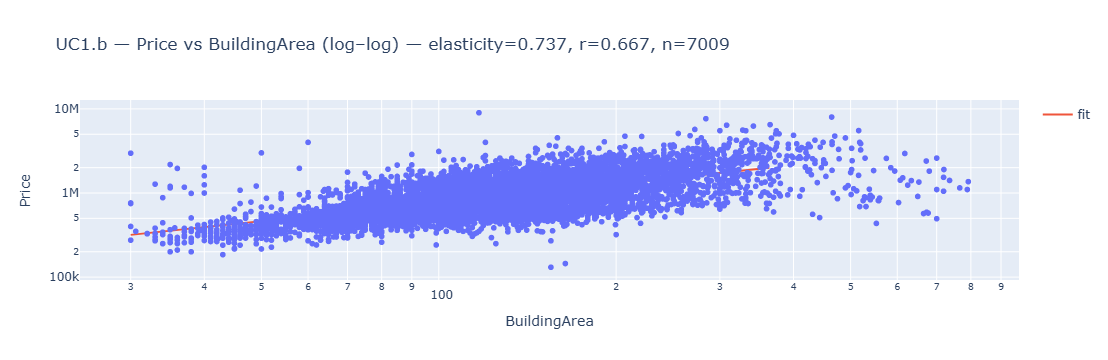

In [58]:
import plotly.graph_objects as go
x = df["BuildingArea"].values; y = df["Price"].values
mask = df["BuildingArea"].between(30, 800) & (df["Price"]>0)
lx,ly = np.log(x[mask]), np.log(y[mask])
k,b = np.polyfit(lx,ly,1); r = np.corrcoef(lx,ly)[0,1]; n = lx.size
xx = np.linspace(x[mask].min(), np.percentile(x[mask],98), 200)
yy = np.exp(k*np.log(xx)+b)
print(f"elasticity={k:.3f}, corr={r:.3f}, n={n}")


dfp = pd.DataFrame({"BuildingArea": x[mask], "Price": y[mask]})
fig = px.scatter(dfp, x="BuildingArea", y="Price",
                 title=f"UC1.b — Price vs BuildingArea (log–log) — elasticity={k:.3f}, r={r:.3f}, n={n}")
fig.add_trace(go.Scatter(x=xx, y=yy, mode="lines", name="fit"))
fig.update_xaxes(type="log", title_text="BuildingArea")
fig.update_yaxes(type="log", title_text="Price")
fig.show()

In [34]:
report='''
Answer:In this data processing, we did not impute missing values for Building Area, as each unit has a unique building area. 
The current regression/scatter plot uses a sample size of n=7,009, which is significantly smaller than the full dataset. 
This introduces the risk of sample selection bias: if the missing data is not random, 
the coefficients and correlation may be systematically overestimated or underestimated.

Without imputing missing Building Area values, and using only the samples with recorded building area data (n=7,009), 
price and building area show a strong positive correlation on a log-log scale: correlation coefficient r ≈ 0.667, elasticity coefficient k ≈ 0.737.  
This means that for every 10% increase in building area, the price increases by approximately 7.4% on average. 

This result indicates a significant marginal effect of area on price, 
but due to the reduced sample size and potential selection bias caused by missing data, 
the magnitude of these values primarily reflects the relationship strength for properties with recorded area data 
and should not be directly extrapolated to all properties.  

Actual property valuation requires comprehensive consideration of factors such as location, property type, land area, and property condition.
'''
print(report)


Answer:In this data processing, we did not impute missing values for Building Area, as each unit has a unique building area. 
The current regression/scatter plot uses a sample size of n=7,009, which is significantly smaller than the full dataset. 
This introduces the risk of sample selection bias: if the missing data is not random, 
the coefficients and correlation may be systematically overestimated or underestimated.

Without imputing missing Building Area values, and using only the samples with recorded building area data (n=7,009), 
price and building area show a strong positive correlation on a log-log scale: correlation coefficient r ≈ 0.667, elasticity coefficient k ≈ 0.737.  
This means that for every 10% increase in building area, the price increases by approximately 7.4% on average. 

This result indicates a significant marginal effect of area on price, 
but due to the reduced sample size and potential selection bias caused by missing data, 
the magnitude of these values pri

In [35]:
report='''UC1.c — Landsize ↔ Price
Question: Do larger lots command higher prices?
'''
print(report)

UC1.c — Landsize ↔ Price
Question: Do larger lots command higher prices?



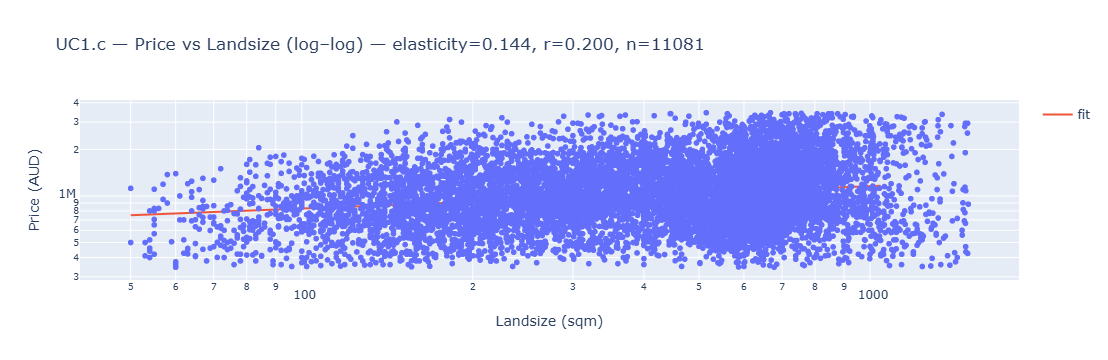

In [128]:
df["Price"]    = pd.to_numeric(df.get("Price"), errors="coerce")
df["Landsize"] = pd.to_numeric(df.get("Landsize"), errors="coerce")
d = df[(df["Price"]>0) & (df["Landsize"]>0)].copy()

p1, p99 = d["Price"].quantile([0.01, 0.99])
d = d[d["Price"].between(p1, p99)]

MIN_LAND, MAX_LAND = 50, 1500
d = d[(d["Landsize"] >= MIN_LAND) & (d["Landsize"] <= MAX_LAND)]

x = d["Landsize"].to_numpy()
y = d["Price"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y) & (x>0) & (y>0)
lx, ly = np.log(x[mask]), np.log(y[mask])

k, b = np.polyfit(lx, ly, 1)          
r = np.corrcoef(lx, ly)[0,1]          
n = lx.size

xx = np.linspace(x[mask].min(), np.percentile(x[mask], 98), 200)
yy = np.exp(k*np.log(xx) + b)

dfp = pd.DataFrame({"Landsize (sqm)": x[mask], "Price (AUD)": y[mask]})
title = f"UC1.c — Price vs Landsize (log–log) — elasticity={k:.3f}, r={r:.3f}, n={n}"
fig = px.scatter(dfp, x="Landsize (sqm)", y="Price (AUD)", title=title)
fig.add_trace(go.Scatter(x=xx, y=yy, mode="lines", name="fit"))
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.show()

In [129]:
report='''
Answer:On the log–log plot there is a weak positive association between land size and price:
elasticity ≈ 0.144, r ≈ 0.200 (n = 11,081).
Interpretation: a 10% increase in land size is associated with only about a 1.4% increase in price on average.

This effect is much weaker than the floor-area effect, implying that the market tends to price built area, location, 
and product type more strongly than raw lot size. 
Treat the fitted line as a market-level tendency; individual properties will vary with zoning, frontage, buildability, and neighborhood desirability.
'''
print(report)


Answer:On the log–log plot there is a weak positive association between land size and price:
elasticity ≈ 0.144, r ≈ 0.200 (n = 11,081).
Interpretation: a 10% increase in land size is associated with only about a 1.4% increase in price on average.

This effect is much weaker than the floor-area effect, implying that the market tends to price built area, location, 
and product type more strongly than raw lot size. 
Treat the fitted line as a market-level tendency; individual properties will vary with zoning, frontage, buildability, and neighborhood desirability.



In [130]:
report='''
UC1.d— Age (from YearBuilt) ↔ Price
Question: Do newer homes price higher?
'''
print(report)


UC1.d— Age (from YearBuilt) ↔ Price
Question: Do newer homes price higher?



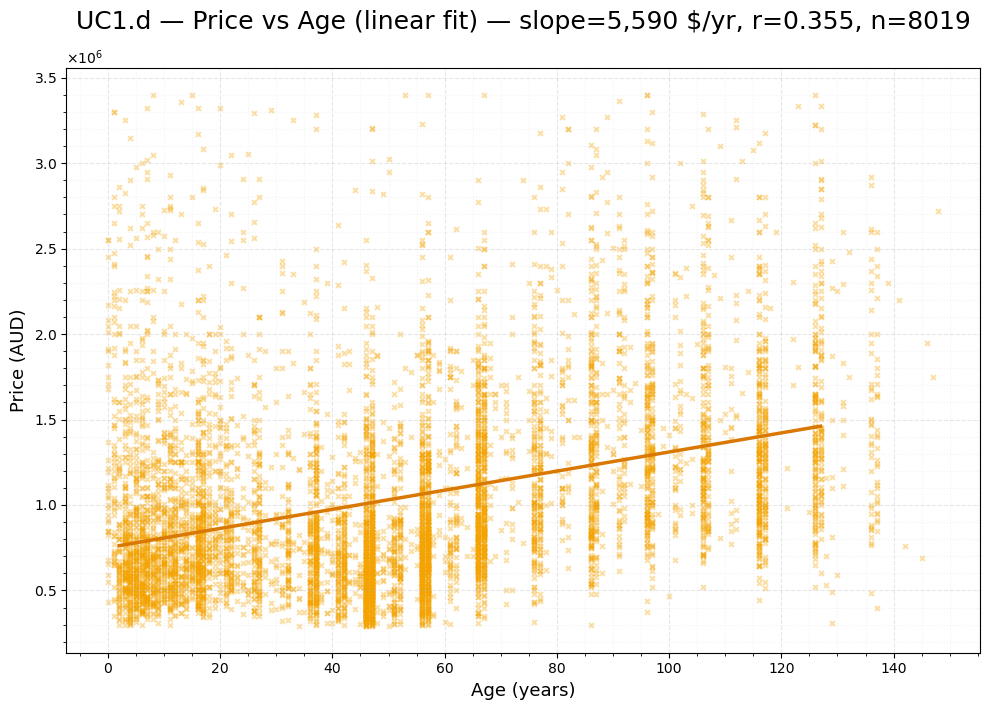

In [131]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
from datetime import datetime

df["Date"] = pd.to_datetime(df.get("Date"), errors="coerce", dayfirst=True)
sale_year = df["Date"].dt.year
df["Price"] = pd.to_numeric(df.get("Price"), errors="coerce")
df["YearBuilt"] = pd.to_numeric(df.get("YearBuilt"), errors="coerce")
df["Age"] = sale_year - df["YearBuilt"]

d = df.dropna(subset=["Price","Age","YearBuilt"]).copy()
d = d[(d["Price"]>0) &
      (d["YearBuilt"].between(1850, datetime.now().year)) &
      (d["Age"].between(0, 150))]

p1, p99 = d["Price"].quantile([0.01, 0.99])
d = d[d["Price"].between(p1, p99)]

X = d["Age"].to_numpy()
Y = d["Price"].to_numpy()
mask = np.isfinite(X) & np.isfinite(Y)
k_lin, b_lin = np.polyfit(X[mask], Y[mask], 1)    
r_lin = np.corrcoef(X[mask], Y[mask])[0, 1]
n = int(mask.sum())

xx = np.linspace(np.percentile(X[mask], 2), np.percentile(X[mask], 98), 200)
yy = k_lin * xx + b_lin

plt.figure(figsize=(10,7.2))
ax = plt.gca()

ax.scatter(X[mask], Y[mask], s=12, marker='x', alpha=0.35, color='#f4a300')

ax.plot(xx, yy, color='#d97904', linewidth=2.5)

ax.set_xlabel("Age (years)", fontsize=13)
ax.set_ylabel("Price (AUD)", fontsize=13)
ax.grid(True, which='major', linestyle='--', alpha=0.3)
ax.grid(True, which='minor', linestyle=':', alpha=0.15)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((6,6))   
ax.yaxis.set_major_formatter(sf)


title = f"UC1.d — Price vs Age (linear fit) — slope={k_lin:,.0f} $/yr, r={r_lin:.3f}, n={n}"
ax.set_title(title, fontsize=18, pad=14)

plt.tight_layout()
plt.show()

In [132]:
report='''
Answer:In this data processing, we also did not impute the "YearBuilt" field, 
as missing values are often non-random: older or renovated houses are more likely to have missing year data, 
and forcing imputation would introduce systematic bias. We lack reliable external features for accurate inference 
(using only "mode/median" based on Suburb/Type/Rooms would smooth out differences between houses of different ages, weakening the true variations). 

Incorrectly imputed years would directly affect the derived variable "Age," introducing the risk of label leakage/bias in the price model. 
Therefore, this analysis only uses records with a definite YearBuilt for plotting and fitting, avoiding unreliable synthetic data.

Without imputing the year, and using only samples with a YearBuilt record (n=8,019), 
linear regression shows: correlation coefficient r ≈ 0.355 (moderate positive correlation); 
slope ≈ A$5,590/year: for every additional year of age, the price increases by approximately A$5.6k. 

This contradicts the intuition that "newer houses are more expensive," 
indicating a strong interplay of location and property type: many older houses are located in prime areas (or are heritage/renovated properties), 
resulting in higher overall prices. This result should be understood as a market correlation for the sample with year data, 
and should not be extrapolated to all properties; 
individual property valuations still require comprehensive consideration of location, property type, land/building size, and condition.
'''
print(report)


Answer:In this data processing, we also did not impute the "YearBuilt" field, 
as missing values are often non-random: older or renovated houses are more likely to have missing year data, 
and forcing imputation would introduce systematic bias. We lack reliable external features for accurate inference 
(using only "mode/median" based on Suburb/Type/Rooms would smooth out differences between houses of different ages, weakening the true variations). 

Incorrectly imputed years would directly affect the derived variable "Age," introducing the risk of label leakage/bias in the price model. 
Therefore, this analysis only uses records with a definite YearBuilt for plotting and fitting, avoiding unreliable synthetic data.

Without imputing the year, and using only samples with a YearBuilt record (n=8,019), 
linear regression shows: correlation coefficient r ≈ 0.355 (moderate positive correlation); 
slope ≈ A$5,590/year: for every additional year of age, the price increases by approximately A

In [133]:
report='''
UC1.e — Type ↔ Price
Question: Do housing types differ materially in price?
'''
print(report)


UC1.e — Type ↔ Price
Question: Do housing types differ materially in price?



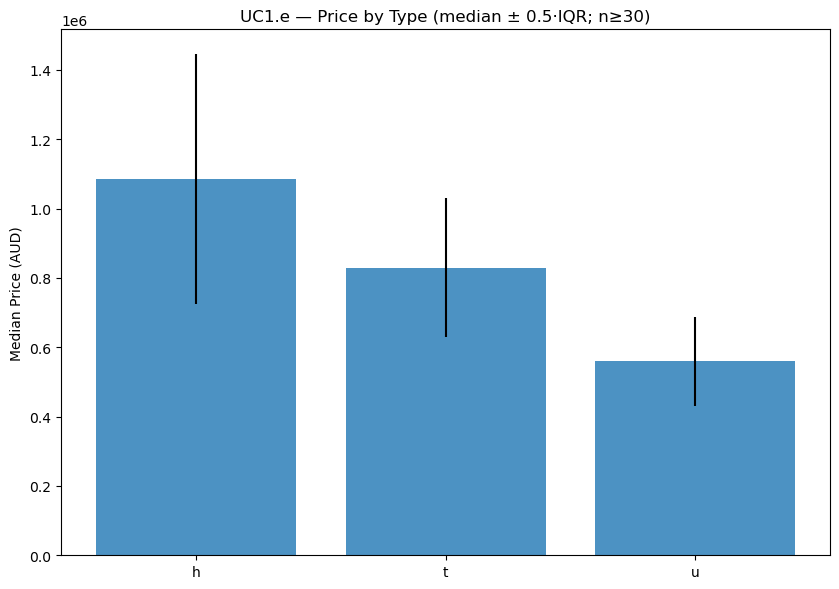

In [134]:
g = (
    d.groupby("Type")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]
MIN_N = 30
g_stable = g[g["count"]>=MIN_N].sort_values("median", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8.5,6))
x = np.arange(len(g_stable))
med = g_stable["median"].values
iqr = g_stable["IQR"].values
labels = g_stable["Type"].astype(str).values

plt.bar(x, med, yerr=iqr/2, alpha=0.8) 
plt.xticks(x, labels)
plt.ylabel("Median Price (AUD)")
plt.title("UC1.e — Price by Type (median ± 0.5·IQR; n≥30)")
plt.tight_layout()
plt.show()

In [135]:
report='''
Answer:Standalone houses are the most expensive, townhouses sit in the middle, and apartments are the least expensive.
Based on this dataset, median prices are roughly A$1.08M for standalone houses, A$0.85M for townhouses, and A$0.56M for apartments.

Price dispersion is wider for houses and townhouses (driven by location, land/building size, and product variety), 
while apartments show a more concentrated price band because units within a building are more standardized.
'''
print(report)


Answer:Standalone houses are the most expensive, townhouses sit in the middle, and apartments are the least expensive.
Based on this dataset, median prices are roughly A$1.08M for standalone houses, A$0.85M for townhouses, and A$0.56M for apartments.

Price dispersion is wider for houses and townhouses (driven by location, land/building size, and product variety), 
while apartments show a more concentrated price band because units within a building are more standardized.



In [136]:
report='''
UC1.g — Method ↔ Price
Question: Do auctions sell higher than private sales?
'''
print(report)


UC1.g — Method ↔ Price
Question: Do auctions sell higher than private sales?



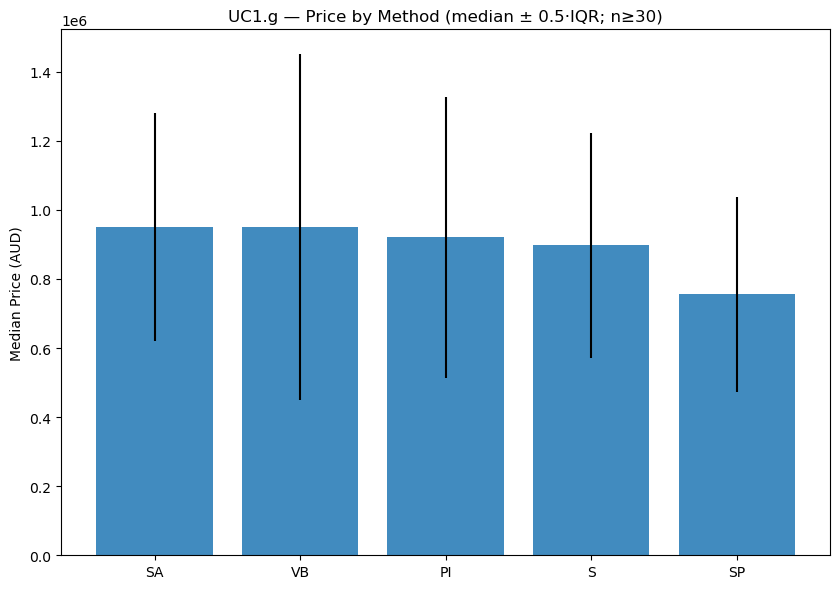

In [137]:
g = (
    d.groupby("Method")["Price"]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
)
g["IQR"] = g["q3"] - g["q1"]
g_stable = g[g["count"]>=30].sort_values("median", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8.5,6))
x = np.arange(len(g_stable))
plt.bar(x, g_stable["median"].values, yerr=g_stable["IQR"].values/2, alpha=0.85)
plt.xticks(x, g_stable["Method"].astype(str).values)
plt.ylabel("Median Price (AUD)")
plt.title("UC1.g — Price by Method (median ± 0.5·IQR; n≥30)")
plt.tight_layout()
plt.show()

In [138]:
report='''
Median prices from auction pathways—S (sold at auction) and SA (sold after auction)—are slightly higher or comparable to other methods.
SP (sold prior) tends to be lower. PI (passed in) / VB (vendor bid) are not arm’s-length sale prices and are for context only.

The IQRs are wide and heavily overlapping across methods, so location, property type, and listing timing remain key drivers.
We cannot assert a consistent, statistically significant premium for auctions from this summary alone.

Treat S+SA (auction) vs non-auction (SP/privates) as the main split; compare within the same type/region/month for fairer pricing insight.
'''
print(report)


Median prices from auction pathways—S (sold at auction) and SA (sold after auction)—are slightly higher or comparable to other methods.
SP (sold prior) tends to be lower. PI (passed in) / VB (vendor bid) are not arm’s-length sale prices and are for context only.

The IQRs are wide and heavily overlapping across methods, so location, property type, and listing timing remain key drivers.
We cannot assert a consistent, statistically significant premium for auctions from this summary alone.

Treat S+SA (auction) vs non-auction (SP/privates) as the main split; compare within the same type/region/month for fairer pricing insight.



In [139]:
report='''
Branch B — Market ↔ Features
UC1.a — Date (seasonality) ↔ Market
Question: Are there seasonal effects on price?
'''
print(report)


Branch B — Market ↔ Features
UC1.a — Date (seasonality) ↔ Market
Question: Are there seasonal effects on price?



In [62]:
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cols = {c.lower(): c for c in df.columns}
DATE  = cols.get("date","Date")
PRICE = cols.get("price","Price")
TYPE  = cols.get("type","Type")
REG   = cols.get("regionname","Regionname")
METH  = cols.get("method","Method")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
df = df[df[PRICE] > 0].copy()
df[DATE] = pd.to_datetime(df[DATE], errors="coerce", dayfirst=True)
df = df[df[DATE].notna()].copy()

df["year"]  = df[DATE].dt.year
df["month"] = df[DATE].dt.month
df["year_month"] = df[DATE].dt.to_period("M").astype(str)

def season_from_month(m):
    if pd.isna(m): return np.nan
    m = int(m)
    if m in [12,1,2]: return "Summer"
    if m in [3,4,5]:  return "Autumn"
    if m in [6,7,8]:  return "Winter"
    return "Spring"
df["season"] = df["month"].map(season_from_month)

fmtM = FuncFormatter(lambda v, _: f"${v/1e6:.1f}M")
outdir = "/mnt/data/seasonality_pack"; os.makedirs(outdir, exist_ok=True)


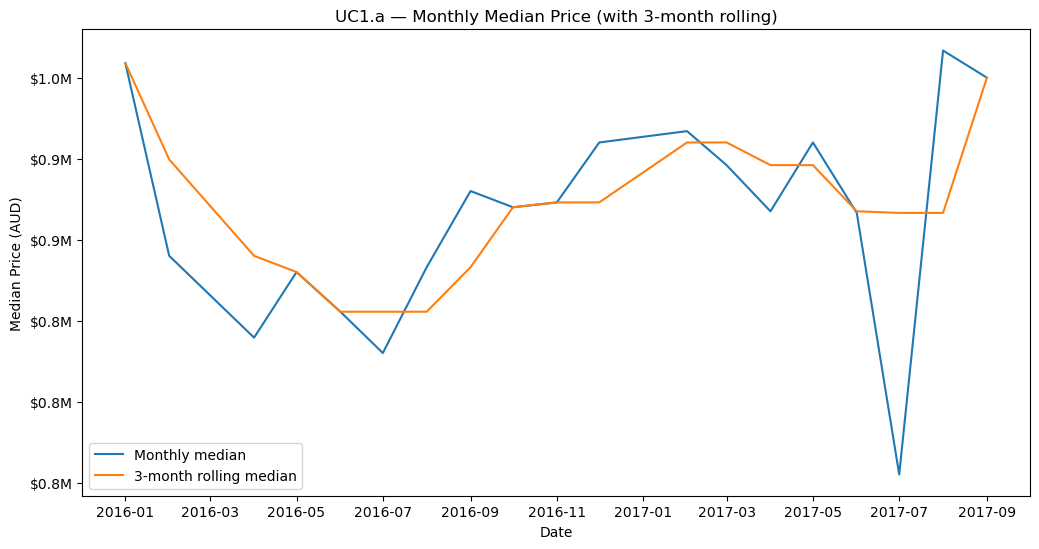


[Support] Monthly sales volume (count by month):
year_month  Count
   2016-01      2
   2016-02     26
   2016-04    318
   2016-05    899
   2016-06    732
   2016-07    446
   2016-08    716
   2016-09    925
   2016-10    551
   2016-11   1114
   2016-12    607
   2017-02    417
   2017-03    678
   2017-04    631
   2017-05   1130
   2017-06   1098
   2017-07   1536
   2017-08    834
   2017-09    920


In [63]:
#  Fig1 — Monthly median 
monthly = (df.groupby("year_month")[PRICE].median()
           .reset_index().rename(columns={PRICE:"MedianPrice"}))
monthly["date"] = pd.to_datetime(monthly["year_month"] + "-01")
monthly = monthly.sort_values("date")
monthly["roll3"] = monthly["MedianPrice"].rolling(3, min_periods=1).median()


plt.figure(figsize=(10.5,5.6))
plt.plot(monthly["date"], monthly["MedianPrice"], label="Monthly median")
plt.plot(monthly["date"], monthly["roll3"], label="3-month rolling median")
plt.gca().yaxis.set_major_formatter(fmtM)
plt.title("UC1.a — Monthly Median Price (with 3-month rolling)")
plt.xlabel("Date"); plt.ylabel("Median Price (AUD)"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir,"01_monthly_median_with_roll3.png"), dpi=140); plt.show()


m_counts = (df.groupby("year_month")[PRICE]
              .size()
              .rename("Count")
              .reset_index()
              .sort_values("year_month"))
print("\n[Support] Monthly sales volume (count by month):")
print(m_counts.to_string(index=False))


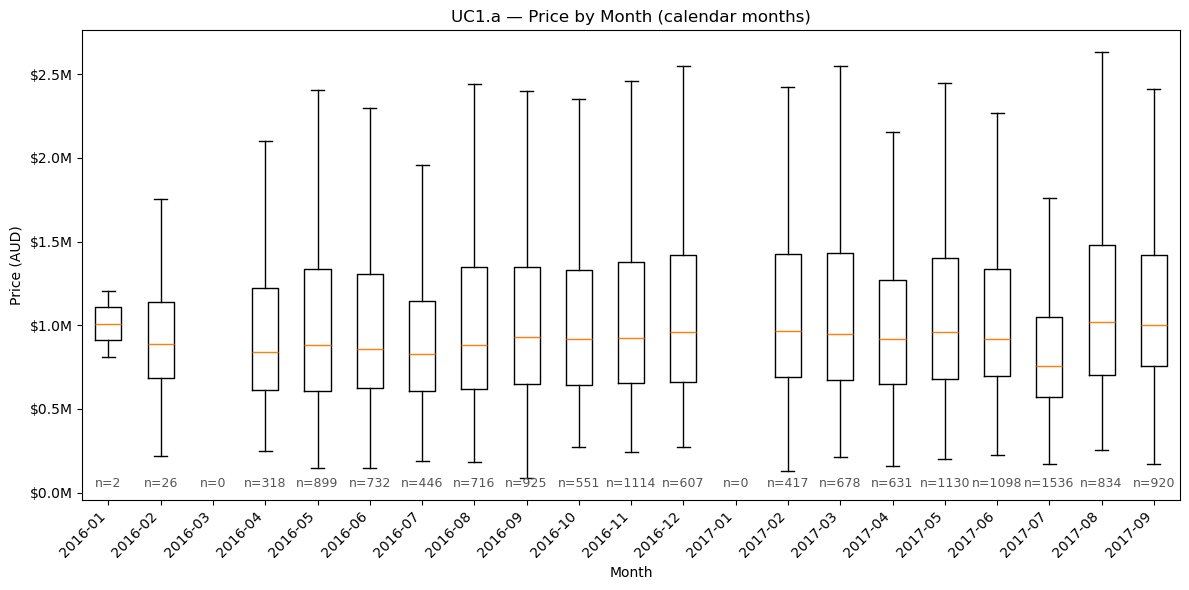


[Support] Monthly median price by year-month:
year_month MedianPrice
   2016-01  $1,009,000
   2016-02    $890,000
   2016-03         NaN
   2016-04    $839,500
   2016-05    $880,000
   2016-06    $855,500
   2016-07    $830,000
   2016-08    $883,000
   2016-09    $930,000
   2016-10    $920,000
   2016-11    $923,000
   2016-12    $960,000
   2017-01         NaN
   2017-02    $967,000
   2017-03    $946,000
   2017-04    $917,500
   2017-05    $960,000
   2017-06    $916,500
   2017-07    $755,000
   2017-08  $1,016,750
   2017-09  $1,000,000


In [64]:
# 4) Fig2 – month-of-year 
df["ym"] = df[DATE].dt.to_period("M")
start = df["ym"].min()
end   = df["ym"].max()
months = pd.period_range(start, end, freq="M")  

box_data = [df.loc[df["ym"] == p, PRICE].dropna().values for p in months]
labels   = [p.strftime("%Y-%m") for p in months]  # 2016-01, 2016-02, ...

fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(box_data, showfliers=False)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title(f"UC1.a — Price by Month (calendar months)")
ax.set_xlabel("Month"); ax.set_ylabel("Price (AUD)")
ax.yaxis.set_major_formatter(fmtM)

y0, y1 = ax.get_ylim()
ns = [len(b) for b in box_data]
for i, n in enumerate(ns, start=1):
    ax.text(i, y0 + 0.02*(y1 - y0), f"n={n}", ha="center", va="bottom", fontsize=9, color="#555")

plt.tight_layout()
plt.show()


ym = df[DATE].dt.to_period("M")

price_by_month = (
    df.groupby(ym)[PRICE].median()          
      .rename("MedianPrice")
      .to_frame()
)

full_idx = pd.period_range(price_by_month.index.min(), price_by_month.index.max(), freq="M")
price_by_month = (
    price_by_month.reindex(full_idx)         
                 .reset_index()
                 .rename(columns={"index":"year_month"})
)

price_by_month["year_month"] = price_by_month["year_month"].astype(str)

print("\n[Support] Monthly median price by year-month:")
print(price_by_month.to_string(
    index=False,
    formatters={"MedianPrice": lambda v: f"${v:,.0f}" if pd.notna(v) else "—"}
))

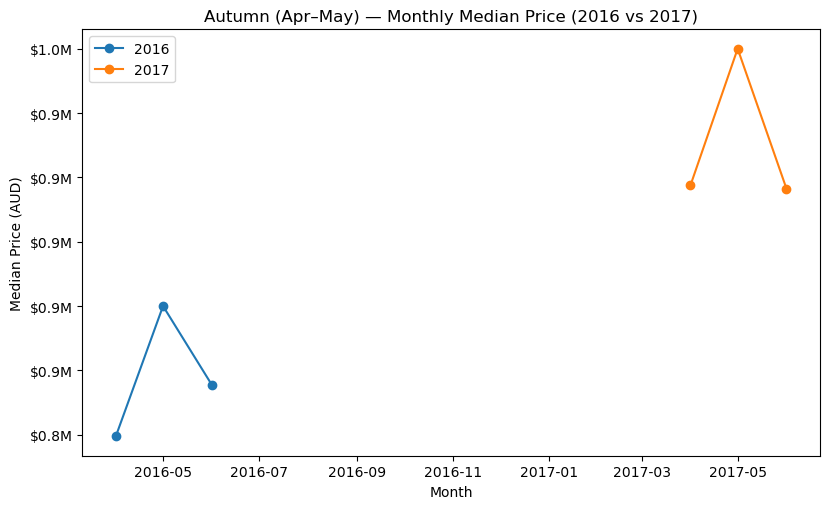


[Support] Autumn (Apr–June) — monthly median & count:
 year year_month   Median  Count
 2016    2016-04 839500.0    318
 2016    2016-05 880000.0    899
 2016    2016-06 855500.0    732
 2017    2017-04 917500.0    631
 2017    2017-05 960000.0   1130
 2017    2017-06 916500.0   1098


In [65]:
# 5) Fig3 – price by season
cols = {c.lower(): c for c in df.columns}
DATE  = cols.get("date","Date")
PRICE = cols.get("price","Price")

d0 = df.copy()
d0[DATE]  = pd.to_datetime(d0[DATE], errors="coerce", dayfirst=True)
d0[PRICE] = pd.to_numeric(d0[PRICE], errors="coerce")
d0 = d0[(d0[PRICE] > 0) & d0[DATE].notna()].copy()

d0["year"]       = d0[DATE].dt.year
d0["month"]      = d0[DATE].dt.month
d0["year_month"] = d0[DATE].dt.to_period("M").astype(str)


d = d0[((d0["year"]==2016) & d0["month"].between(4,12)) |
       ((d0["year"]==2017) & d0["month"].between(4, 9))].copy()

fmtM = FuncFormatter(lambda v,_: f"${v/1e6:.1f}M")


def ym_str_to_ts(ym_str):
    return pd.to_datetime(ym_str + "-01")

#Autumn
aut = d[d["month"].isin([4,5,6])].copy()
aut_med = (aut.groupby(["year","year_month"])[PRICE]
             .median().reset_index()
             .sort_values(["year","year_month"]))
aut_med["date"] = aut_med["year_month"].map(ym_str_to_ts)

fig, ax = plt.subplots(figsize=(8.4,5.2))
for yr, g in aut_med.groupby("year"):
    ax.plot(g["date"], g[PRICE], marker="o", label=str(yr))
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Autumn (Apr–May) — Monthly Median Price (2016 vs 2017)")
ax.set_xlabel("Month"); ax.set_ylabel("Median Price (AUD)")
ax.legend(); plt.tight_layout(); plt.show()


aut_tbl_med = (aut.groupby(["year","year_month"])[PRICE]
                 .median().rename("Median").reset_index())
aut_tbl_n   = (aut.groupby(["year","year_month"])[PRICE]
                 .size().rename("Count").reset_index())
aut_tbl = (aut_tbl_med.merge(aut_tbl_n, on=["year","year_month"])
                    .sort_values(["year","year_month"]))
print("\n[Support] Autumn (Apr–June) — monthly median & count:")
print(aut_tbl.to_string(index=False))

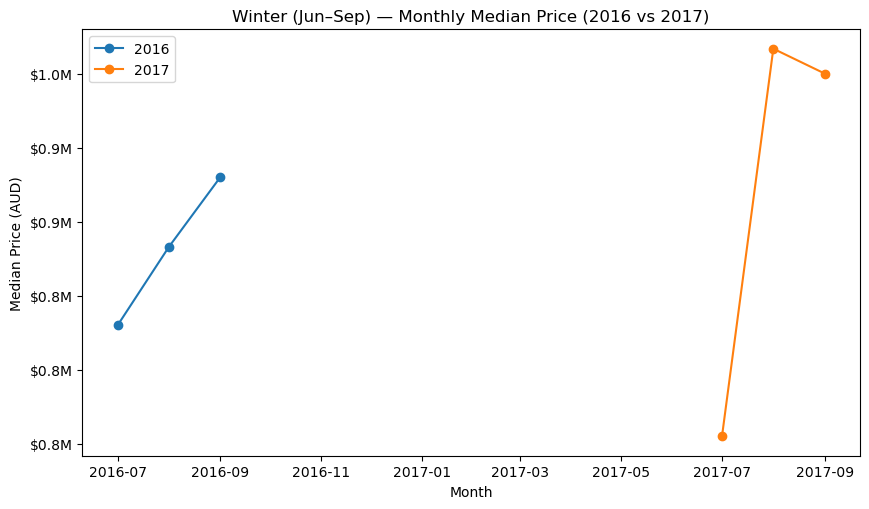


[Support] Winter (July–Sep) — monthly median & count:
 year year_month    Median  Count
 2016    2016-07  830000.0    446
 2016    2016-08  883000.0    716
 2016    2016-09  930000.0    925
 2017    2017-07  755000.0   1536
 2017    2017-08 1016750.0    834
 2017    2017-09 1000000.0    920


In [66]:
#winter
win = d[d["month"].isin([7,8,9])].copy()
win_med = (win.groupby(["year","year_month"])[PRICE]
             .median().reset_index()
             .sort_values(["year","year_month"]))
win_med["date"] = win_med["year_month"].map(ym_str_to_ts)

fig, ax = plt.subplots(figsize=(8.8,5.2))
for yr, g in win_med.groupby("year"):
    ax.plot(g["date"], g[PRICE], marker="o", label=str(yr))
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Winter (Jun–Sep) — Monthly Median Price (2016 vs 2017)")
ax.set_xlabel("Month"); ax.set_ylabel("Median Price (AUD)")
ax.legend(); plt.tight_layout(); plt.show()


win_tbl_med = (win.groupby(["year","year_month"])[PRICE]
                 .median().rename("Median").reset_index())
win_tbl_n   = (win.groupby(["year","year_month"])[PRICE]
                 .size().rename("Count").reset_index())
win_tbl = (win_tbl_med.merge(win_tbl_n, on=["year","year_month"])
                    .sort_values(["year","year_month"]))
print("\n[Support] Winter (July–Sep) — monthly median & count:")
print(win_tbl.to_string(index=False))

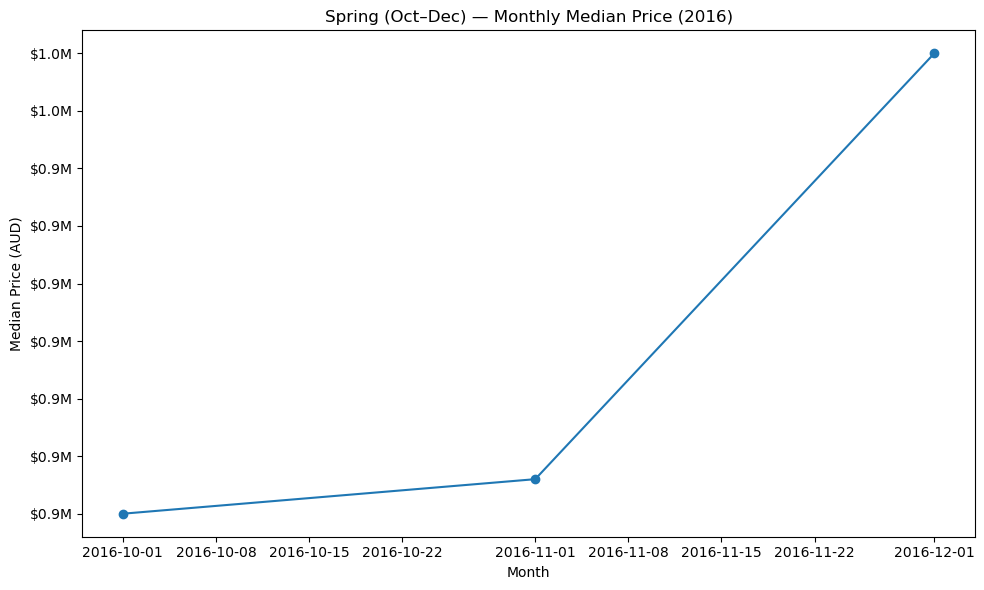


[Support] Spring (Oct–Dec) 2016 — monthly median & count:
year_month   Median  Count
   2016-10 920000.0    551
   2016-11 923000.0   1114
   2016-12 960000.0    607


In [67]:
#Spring
spr = d[(d["year"]==2016) & (d["month"].isin([10,11,12]))].copy()
spr_med = (spr.groupby("year_month")[PRICE]
             .median().reset_index()
             .sort_values("year_month"))
spr_med["date"] = spr_med["year_month"].map(ym_str_to_ts)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spr_med["date"], spr_med[PRICE], marker="o")
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Spring (Oct–Dec) — Monthly Median Price (2016)")
ax.set_xlabel("Month"); ax.set_ylabel("Median Price (AUD)")
plt.tight_layout(); plt.show()

spr_tbl_med = (spr.groupby("year_month")[PRICE]
                 .median().rename("Median").reset_index())
spr_tbl_n   = (spr.groupby("year_month")[PRICE]
                 .size().rename("Count").reset_index())
spr_tbl = (spr_tbl_med.merge(spr_tbl_n, on="year_month")
                    .sort_values("year_month"))
print("\n[Support] Spring (Oct–Dec) 2016 — monthly median & count:")
print(spr_tbl.to_string(index=False))

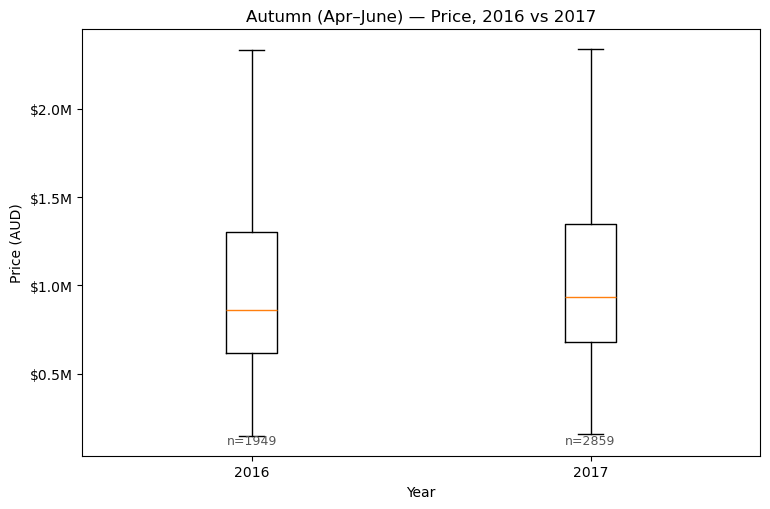


[Support] Autumn (Apr–June) — median & count by year:
        Median  Count
year                 
2016  860000.0   1949
2017  935000.0   2859


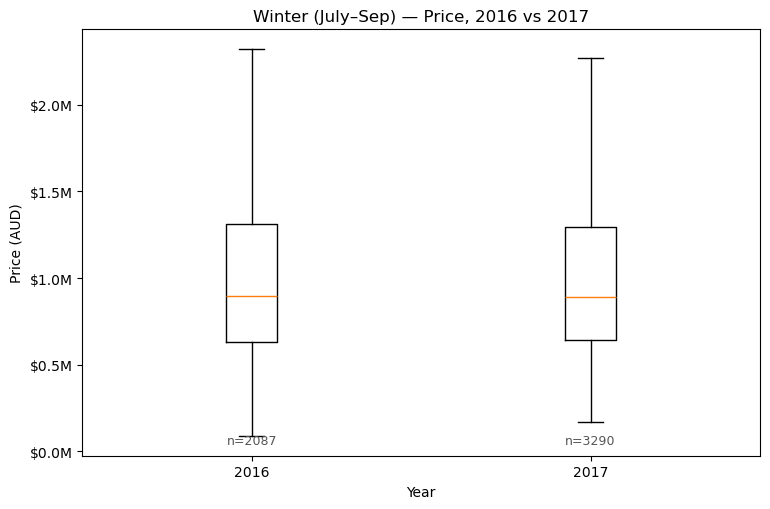


[Support] Winter (July–Sep) — median & count by year:
        Median  Count
year                 
2016  895000.0   2087
2017  887750.0   3290


In [68]:
cols = {c.lower(): c for c in df.columns}
DATE  = cols.get("date","Date")
PRICE = cols.get("price","Price")

df = df.copy()
df[DATE]  = pd.to_datetime(df[DATE], errors="coerce", dayfirst=True)
df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
df = df[(df[PRICE] > 0) & df[DATE].notna()].copy()

df["year"]  = df[DATE].dt.year
df["month"] = df[DATE].dt.month

fmtM = FuncFormatter(lambda v,_: f"${v/1e6:.1f}M")


mask_keep = (
    ((df["year"]==2016) & df["month"].between(4, 12)) |
    ((df["year"]==2017) & df["month"].between(4,  9))
)
d = df.loc[mask_keep].copy()


def my_season(m):
    if   m in [4,5,6]:
        return "Autumn (Apr–June)"
    elif m in [7,8,9]:
        return "Winter (July–Sep)"
    elif m in [10,11,12]:   return "Spring (Oct–Dec)"
    else:                   return np.nan

d["my_season"] = d["month"].map(my_season)

#Autumn
aut = d[d["my_season"]=="Autumn (Apr–June)"].copy()
order_aut = ["2016","2017"]
box_aut   = [aut.loc[aut["year"]==int(y), PRICE].dropna().values for y in order_aut]

fig, ax = plt.subplots(figsize=(7.8,5.2))
ax.boxplot(box_aut, showfliers=False)
ax.set_xticks(np.arange(1, len(order_aut)+1)); ax.set_xticklabels(order_aut)
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Autumn (Apr–June) — Price, 2016 vs 2017")
ax.set_xlabel("Year"); ax.set_ylabel("Price (AUD)")
y0,y1 = ax.get_ylim()
for i, arr in enumerate(box_aut, 1):
    ax.text(i, y0+0.02*(y1-y0), f"n={len(arr)}", ha="center", va="bottom", fontsize=9, color="#555")
plt.tight_layout(); plt.show()


aut_tbl = (aut.groupby("year")[PRICE]
             .agg(Median="median", Count="size")
             .reindex([2016,2017]))
print("\n[Support] Autumn (Apr–June) — median & count by year:")
print(aut_tbl.to_string())

#winter
win = d[d["my_season"]=="Winter (July–Sep)"].copy()
order_win = ["2016","2017"]
box_win   = [win.loc[win["year"]==int(y), PRICE].dropna().values for y in order_win]

fig, ax = plt.subplots(figsize=(7.8,5.2))
ax.boxplot(box_win, showfliers=False)
ax.set_xticks(np.arange(1, len(order_win)+1)); ax.set_xticklabels(order_win)
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Winter (July–Sep) — Price, 2016 vs 2017")
ax.set_xlabel("Year"); ax.set_ylabel("Price (AUD)")
y0,y1 = ax.get_ylim()
for i, arr in enumerate(box_win, 1):
    ax.text(i, y0+0.02*(y1-y0), f"n={len(arr)}", ha="center", va="bottom", fontsize=9, color="#555")
plt.tight_layout(); plt.show()

win_tbl = (win.groupby("year")[PRICE]
             .agg(Median="median", Count="size")
             .reindex([2016,2017]))
print("\n[Support] Winter (July–Sep) — median & count by year:")
print(win_tbl.to_string())

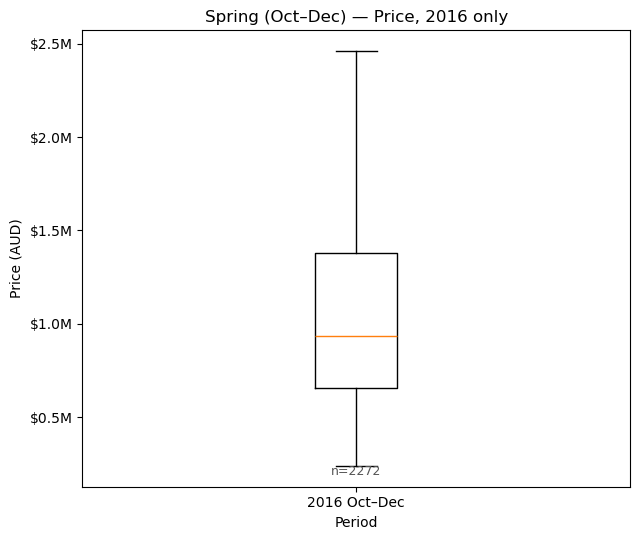


[Support] Spring (Oct–Dec) 2016 — median & count:
                Median  Count
2016 Oct–Dec  935000.0   2272


In [69]:
#Spring
spr = d[(d["my_season"]=="Spring (Oct–Dec)") & (d["year"]==2016)].copy()
box_spr = [spr[PRICE].dropna().values]

fig, ax = plt.subplots(figsize=(6.5,5.5))
ax.boxplot(box_spr, showfliers=False)
ax.set_xticks([1]); ax.set_xticklabels(["2016 Oct–Dec"])
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Spring (Oct–Dec) — Price, 2016 only")
ax.set_xlabel("Period"); ax.set_ylabel("Price (AUD)")
y0,y1 = ax.get_ylim()
ax.text(1, y0+0.02*(y1-y0), f"n={len(box_spr[0])}", ha="center", va="bottom", fontsize=9, color="#555")
plt.tight_layout(); plt.show()


spr_tbl = pd.DataFrame(
    {"Median":[spr[PRICE].median()], "Count":[spr.shape[0]]},
    index=["2016 Oct–Dec"]
)
print("\n[Support] Spring (Oct–Dec) 2016 — median & count:")
print(spr_tbl.to_string())

In [70]:
report='''
A. Market Price Fluctuations with Seasons in Australia (Figures 1–3)

The total sample includes valid transactions, n=13,580.

'''
print(report)


A. Market Price Fluctuations with Seasons in Australia (Figures 1–3)

The total sample includes valid transactions, n=13,580.




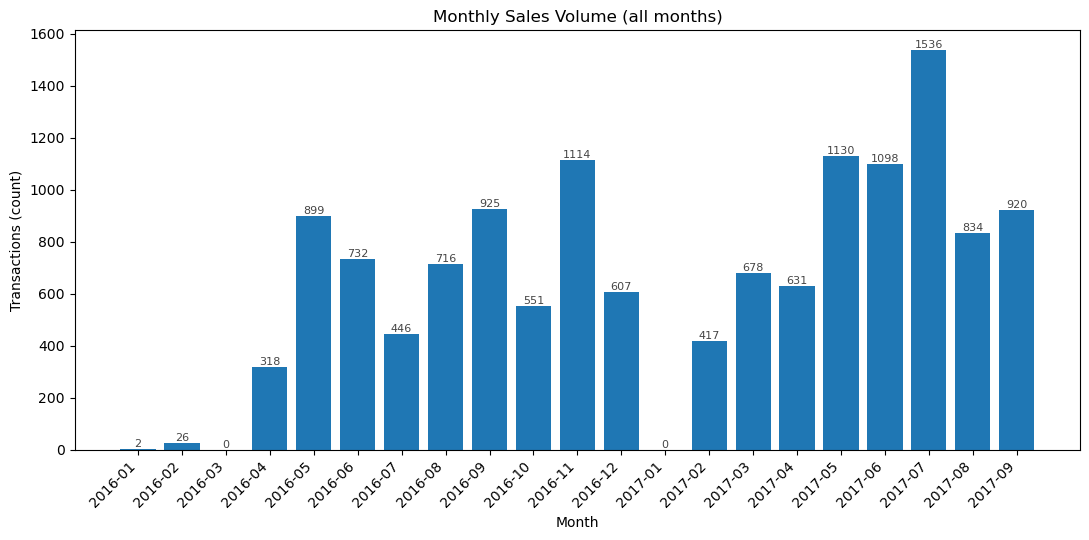


[Support] Monthly sales volume (count by month):
  label  Count
2016-01      2
2016-02     26
2016-03      0
2016-04    318
2016-05    899
2016-06    732
2016-07    446
2016-08    716
2016-09    925
2016-10    551
2016-11   1114
2016-12    607
2017-01      0
2017-02    417
2017-03    678
2017-04    631
2017-05   1130
2017-06   1098
2017-07   1536
2017-08    834
2017-09    920


In [71]:
#Fig4 – monthly volume
ym = df[DATE].dt.to_period("M")
counts = ym.value_counts().sort_index()

full_idx = pd.period_range(ym.min(), ym.max(), freq="M")
vol = counts.reindex(full_idx, fill_value=0).rename_axis("year_month").reset_index(name="Count")
vol["label"] = vol["year_month"].astype(str)

fig, ax = plt.subplots(figsize=(11, 5.5))
bars = ax.bar(range(len(vol)), vol["Count"])
ax.set_xticks(range(len(vol))); ax.set_xticklabels(vol["label"], rotation=45, ha="right")
ax.set_title("Monthly Sales Volume (all months)")
ax.set_xlabel("Month"); ax.set_ylabel("Transactions (count)")

for b in bars:
    ax.text(b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{int(b.get_height())}",
            ha="center", va="bottom", fontsize=8, color="#444")

fig.tight_layout(); plt.show()

print("\n[Support] Monthly sales volume (count by month):")
print(vol[["label", "Count"]].to_string(index=False))


[Support] Auction intensity by month:
year_month  Share  Auctions  Total
   2016-01  100.0         2      2
   2016-02   69.2        18     26
   2016-04   62.6       199    318
   2016-05   61.5       553    899
   2016-06   62.8       460    732
   2016-07   67.5       301    446
   2016-08   66.9       479    716
   2016-09   70.2       649    925
   2016-10   67.3       371    551
   2016-11   67.1       748   1114
   2016-12   67.5       410    607
   2017-02   70.0       292    417
   2017-03   67.6       458    678
   2017-04   68.3       431    631
   2017-05   70.7       799   1130
   2017-06   65.3       717   1098
   2017-07   69.2      1063   1536
   2017-08   65.9       550    834
   2017-09   66.7       614    920


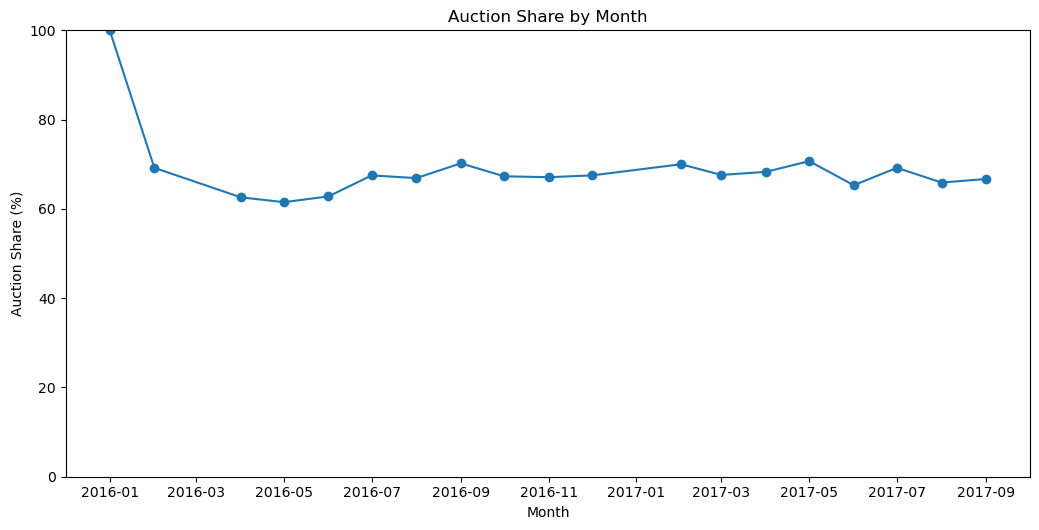

In [72]:
# Fig5 – auction share by month
auction_methods = {"S","SA"}
df["is_auction"] = df[METH].astype(str).str.upper().isin(auction_methods)

au = (df.groupby("year_month")["is_auction"]
        .agg(Total="size", Auctions="sum", Share=lambda s: s.mean()*100)
        .reset_index())
au["date"] = pd.to_datetime(au["year_month"] + "-01"); au = au.sort_values("date")
au["Share"] = au["Share"].round(1)

print("\n[Support] Auction intensity by month:")
print(au[["year_month","Share","Auctions","Total"]].to_string(index=False))


plt.figure(figsize=(10.5,5.4))
plt.plot(au["date"], au["Share"], marker="o")
plt.ylim(0,100)
plt.title("Auction Share by Month")
plt.xlabel("Month"); plt.ylabel("Auction Share (%)")
plt.tight_layout(); plt.savefig(os.path.join(outdir,"05_auction_share_by_month.png"), dpi=140); plt.show()


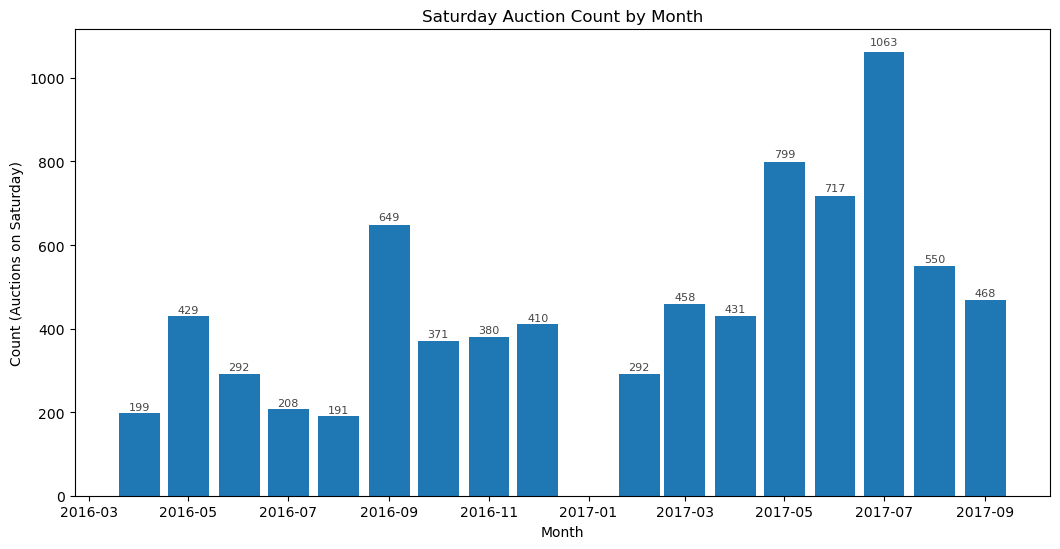


[Support] Saturday auction counts by month:
year_month  SaturdayAuctions       date
   2016-04               199 2016-04-01
   2016-05               429 2016-05-01
   2016-06               292 2016-06-01
   2016-07               208 2016-07-01
   2016-08               191 2016-08-01
   2016-09               649 2016-09-01
   2016-10               371 2016-10-01
   2016-11               380 2016-11-01
   2016-12               410 2016-12-01
   2017-02               292 2017-02-01
   2017-03               458 2017-03-01
   2017-04               431 2017-04-01
   2017-05               799 2017-05-01
   2017-06               717 2017-06-01
   2017-07              1063 2017-07-01
   2017-08               550 2017-08-01
   2017-09               468 2017-09-01


In [73]:
# 8) Fig6 – Saturday auction count
df["weekday"]=df[DATE].dt.weekday
sat = df[df["is_auction"] & (df["weekday"]==5)].groupby("year_month")[PRICE].size().reset_index(name="SaturdayAuctions")
sat["date"]=pd.to_datetime(sat["year_month"]+"-01"); sat=sat.sort_values("date")

plt.figure(figsize=(10.7,5.6))
bars = plt.bar(sat["date"], sat["SaturdayAuctions"], width=25)
plt.title("Saturday Auction Count by Month")
plt.xlabel("Month"); plt.ylabel("Count (Auctions on Saturday)")
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{int(b.get_height())}",
             ha="center", va="bottom", fontsize=8, color="#444")
plt.tight_layout(); plt.savefig(os.path.join(outdir,"06_saturday_auction_counts.png"), dpi=140); plt.show()

print("\n[Support] Saturday auction counts by month:")
print(sat.to_string(index=False))

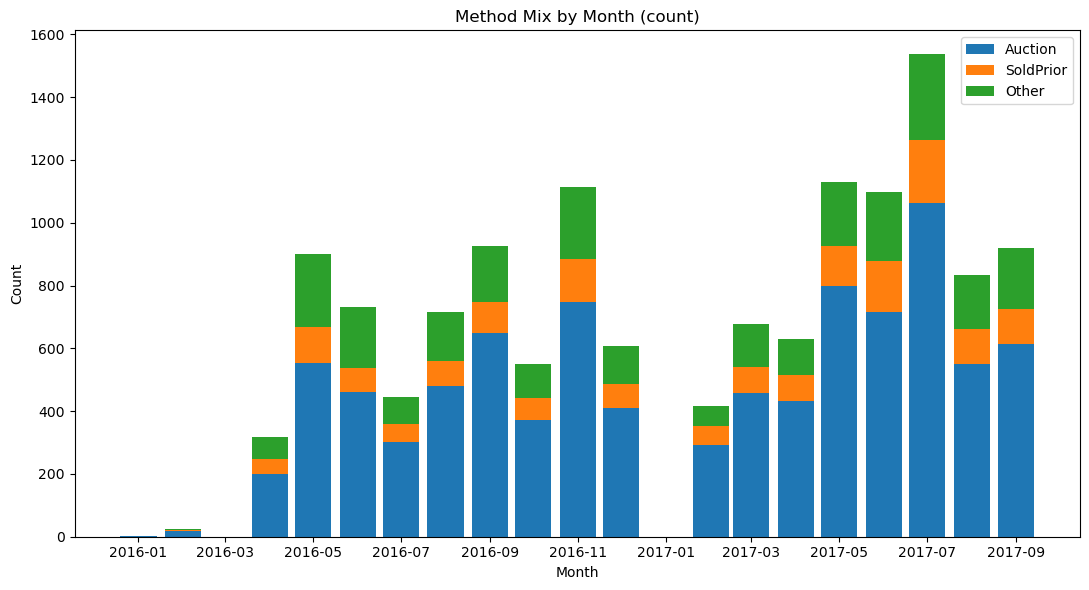


[Support] Method mix by month (counts):
  Month  Auction  SoldPrior  Other
2016-01      2.0        0.0    0.0
2016-02     18.0        2.0    6.0
2016-04    199.0       48.0   71.0
2016-05    553.0      115.0  231.0
2016-06    460.0       77.0  195.0
2016-07    301.0       59.0   86.0
2016-08    479.0       80.0  157.0
2016-09    649.0      100.0  176.0
2016-10    371.0       71.0  109.0
2016-11    748.0      138.0  228.0
2016-12    410.0       75.0  122.0
2017-02    292.0       61.0   64.0
2017-03    458.0       81.0  139.0
2017-04    431.0       83.0  117.0
2017-05    799.0      126.0  205.0
2017-06    717.0      162.0  219.0
2017-07   1063.0      202.0  271.0
2017-08    550.0      112.0  172.0
2017-09    614.0      111.0  195.0


In [74]:
# 9) Fig7 – method mix by month
def bucket(m):
    m=str(m).upper()
    if m in {"S","SA"}: return "Auction"
    if m=="SP": return "SoldPrior"
    return "Other"
df["MethodBucket"]=df[METH].map(bucket)
mix=(df.groupby(["year_month","MethodBucket"])[PRICE].size().reset_index(name="Count"))
mix["date"]=pd.to_datetime(mix["year_month"]+"-01")
pv=mix.pivot_table(index="date", columns="MethodBucket", values="Count", fill_value=0).sort_index()
pv=pv.reindex(columns=["Auction","SoldPrior","Other"], fill_value=0)


fig,ax = plt.subplots(figsize=(11,6))
bottom = np.zeros(len(pv))
for c in pv.columns:
    ax.bar(pv.index, pv[c].values, bottom=bottom, label=c, width=25)
    bottom += pv[c].values
ax.set_title("Method Mix by Month (count)")
ax.set_xlabel("Month"); ax.set_ylabel("Count"); ax.legend()
plt.tight_layout(); plt.savefig(os.path.join(outdir,"07_method_mix_by_month.png"), dpi=140); plt.show()


print("\n[Support] Method mix by month (counts):")
support_mix = pv.reset_index().rename(columns={"date":"Month"})
support_mix["Month"] = support_mix["Month"].dt.strftime("%Y-%m")
print(support_mix.to_string(index=False))

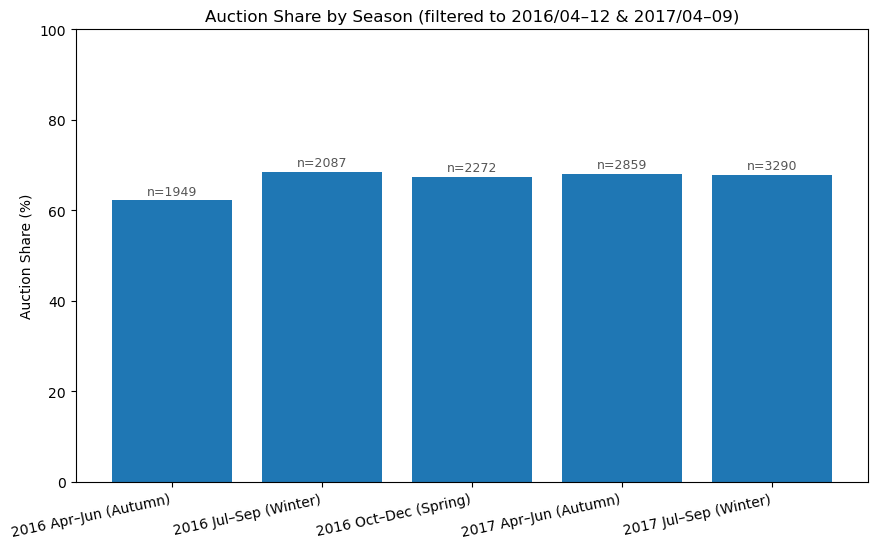


[Support] Auction share by period (filtered):
               Period  Share  Count
2016 Apr–Jun (Autumn)   62.2   1949
2016 Jul–Sep (Winter)   68.5   2087
2016 Oct–Dec (Spring)   67.3   2272
2017 Apr–Jun (Autumn)   68.1   2859
2017 Jul–Sep (Winter)   67.7   3290


In [75]:
# 12) Fig8 – auction share by season
auction_methods = {"S", "SA"}
df["is_auction"] = df[METH].astype(str).str.upper().isin(auction_methods)

def period_label(dt):
    y, m = dt.year, dt.month
    if y == 2016 and m in (4,5,6):   return "2016 Apr–Jun (Autumn)"
    if y == 2016 and m in (7,8,9):   return "2016 Jul–Sep (Winter)"
    if y == 2016 and m in (10,11,12):return "2016 Oct–Dec (Spring)"
    if y == 2017 and m in (4,5,6):   return "2017 Apr–Jun (Autumn)"
    if y == 2017 and m in (7,8,9):   return "2017 Jul–Sep (Winter)"
    return np.nan  # 其余全部剔除（包括 2016/01–03 与 2017/01–03）

df["_period10"] = df[DATE].map(period_label)
d10 = df[df["_period10"].notna()].copy()

order10 = [
    "2016 Apr–Jun (Autumn)",
    "2016 Jul–Sep (Winter)",
    "2016 Oct–Dec (Spring)",
    "2017 Apr–Jun (Autumn)",
    "2017 Jul–Sep (Winter)",
]

au_period = (
    d10.groupby("_period10", observed=True)["is_auction"]
       .agg(Share=lambda s: s.mean()*100, Count="size")
       .reset_index()
       .rename(columns={"_period10":"Period"})
       .set_index("Period").reindex(order10).reset_index()
)
au_period["Share"] = au_period["Share"].round(1)

plt.figure(figsize=(9, 5.6))
bars = plt.bar(au_period["Period"], au_period["Share"])
plt.ylim(0, 100)
plt.xticks(rotation=12, ha="right")
plt.ylabel("Auction Share (%)")
plt.title("Auction Share by Season (filtered to 2016/04–12 & 2017/04–09)")

for b, n in zip(bars, au_period["Count"].tolist()):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()*1.01,
             f"n={int(n)}", ha="center", va="bottom", fontsize=9, color="#555")
plt.tight_layout()
plt.show()

print("\n[Support] Auction share by period (filtered):")
print(au_period.to_string(index=False))

In [83]:
report='''
B. Auctions: Seasonal influences are more strongly reflected in "Market Activity/Auction Frequency" (Figures 4-8).

'''
print(report)


B. Auctions: Seasonal influences are more strongly reflected in "Market Activity/Auction Frequency" (Figures 4-8).





[Support] Median & Count by period × type (h/u):
      period Type  MedianPrice    n
2016 Apr–Jun    h    1055900.0 1286
2016 Apr–Jun    u     532500.0  502
2016 Jul–Sep    h    1110000.0 1346
2016 Jul–Sep    u     540000.0  555
2016 Oct–Dec    h    1175000.0 1520
2016 Oct–Dec    u     540000.0  568
2017 Apr–Jun    h    1110000.0 1966
2017 Apr–Jun    u     600000.0  641
2017 Jul–Sep    h     955000.0 2610
2017 Jul–Sep    u     570000.0  452


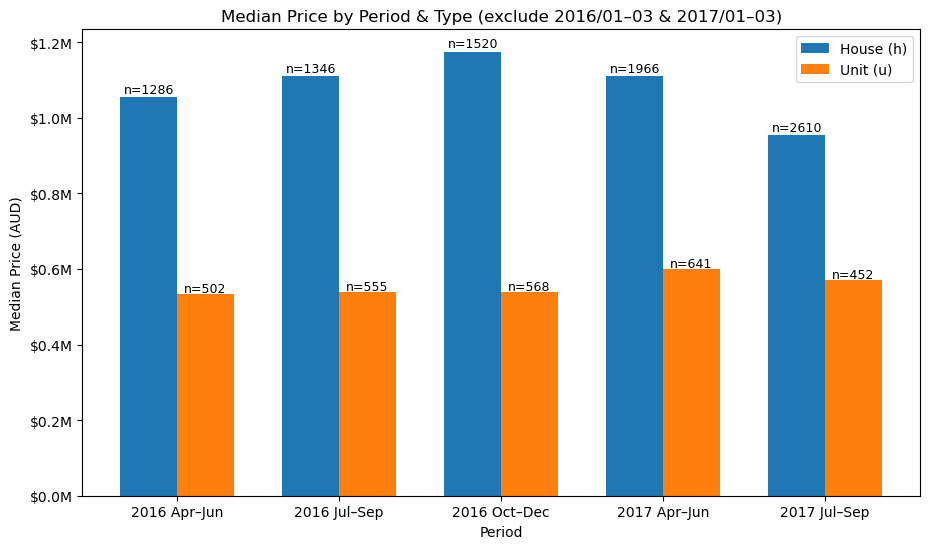

In [81]:
# Fig9 — Median price by Season & Type (h vs u)
cols = {c.lower(): c for c in df.columns}
DATE  = cols.get("date",  "Date")
PRICE = cols.get("price", "Price")
TYPE  = cols.get("type",  "Type")

d = df.copy()
d[DATE]  = pd.to_datetime(d[DATE], errors="coerce", dayfirst=True)
d[PRICE] = pd.to_numeric(d[PRICE], errors="coerce")
d = d[(d[PRICE] > 0) & d[DATE].notna()].copy()
d["year"]  = d[DATE].dt.year
d["month"] = d[DATE].dt.month
d[TYPE]    = d[TYPE].astype("string").str.strip().str.lower()

d = d[d[TYPE].isin(["h","u"])].copy()


mask = (
    ((d["year"]==2016) & d["month"].between(4,12)) |
    ((d["year"]==2017) & d["month"].between(4, 9))
)
d = d.loc[mask].copy()

def yoq(y, m):
    if m in [4,5,6]:
        seg = "Apr–Jun"
    elif m in [7,8,9]:
        seg = "Jul–Sep"
    else:
        seg = "Oct–Dec"
    return f"{y} {seg}"

d["period"] = d.apply(lambda r: yoq(r["year"], r["month"]), axis=1)


order = ["2016 Apr–Jun","2016 Jul–Sep","2016 Oct–Dec",
         "2017 Apr–Jun","2017 Jul–Sep"]
d = d[d["period"].isin(order)].copy()
d["period"] = pd.Categorical(d["period"], categories=order, ordered=True)


med = (d.groupby(["period", TYPE], observed=True)[PRICE]
         .median().reset_index(name="MedianPrice"))

# count
cnt = (d.groupby(["period", TYPE], observed=True)[PRICE]
         .size().reset_index(name="n"))
stat = med.merge(cnt, on=["period", TYPE]).sort_values(["period", TYPE])


print("\n[Support] Median & Count by period × type (h/u):")
print(stat.to_string(index=False))


fmtM = FuncFormatter(lambda v,_: f"${v/1e6:.1f}M")


pv_price = med.pivot(index="period", columns=TYPE, values="MedianPrice").reindex(order)
pv_cnt   = cnt.pivot(index="period", columns=TYPE, values="n").reindex(order).fillna(0).astype(int)

x = np.arange(len(pv_price.index))
w = 0.35

fig, ax = plt.subplots(figsize=(9.4,5.6))
b_h = ax.bar(x-w/2, pv_price.get("h", pd.Series(index=pv_price.index, dtype=float)).values,
             width=w, label="House (h)")
b_u = ax.bar(x+w/2, pv_price.get("u", pd.Series(index=pv_price.index, dtype=float)).values,
             width=w, label="Unit (u)")

ax.set_xticks(x); ax.set_xticklabels(pv_price.index, rotation=0)
ax.yaxis.set_major_formatter(fmtM)
ax.set_title("Median Price by Period & Type (exclude 2016/01–03 & 2017/01–03)")
ax.set_xlabel("Period"); ax.set_ylabel("Median Price (AUD)")
ax.legend()

for i, (bh, bu) in enumerate(zip(b_h, b_u)):
    nh = int(pv_cnt.iloc[i].get("h", 0)); nu = int(pv_cnt.iloc[i].get("u", 0))
    ax.text(bh.get_x()+bh.get_width()/2, bh.get_height()*1.01, f"n={nh}", ha="center", fontsize=9)
    ax.text(bu.get_x()+bu.get_width()/2, bu.get_height()*1.01, f"n={nu}", ha="center", fontsize=9)

plt.tight_layout(); plt.show()

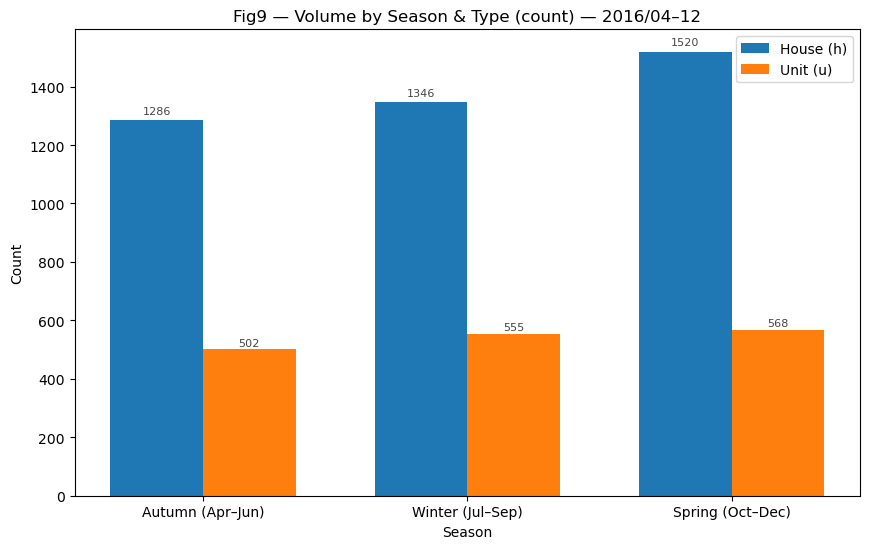


[Support] Season × Type — volume (count) — 2016/04–12:
          season Type  Count
Autumn (Apr–Jun)    h   1286
Autumn (Apr–Jun)    u    502
Winter (Jul–Sep)    h   1346
Winter (Jul–Sep)    u    555
Spring (Oct–Dec)    h   1520
Spring (Oct–Dec)    u    568


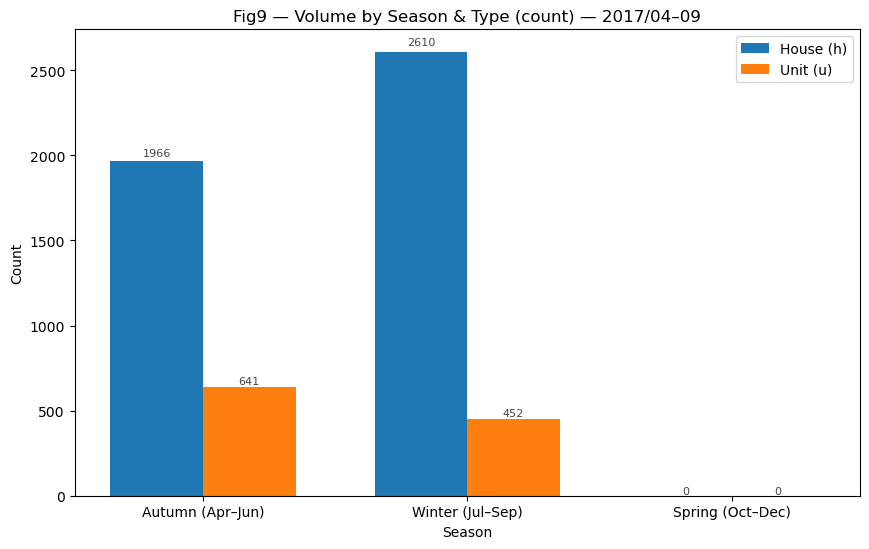


[Support] Season × Type — volume (count) — 2017/04–09:
          season Type  Count
Autumn (Apr–Jun)    h   1966
Autumn (Apr–Jun)    u    641
Winter (Jul–Sep)    h   2610
Winter (Jul–Sep)    u    452
Spring (Oct–Dec)    h      0
Spring (Oct–Dec)    u      0


In [82]:
# 11) Fig10 – season × type (volume)
d = df.copy()
d["year"]  = d[DATE].dt.year
d["month"] = d[DATE].dt.month

keep = ((d["year"]==2016) & d["month"].between(4,12)) | ((d["year"]==2017) & d["month"].between(4,9))
d = d.loc[keep].copy()

def my_season(m):
    if m in (4,5,6):   return "Autumn (Apr–Jun)"
    if m in (7,8,9):   return "Winter (Jul–Sep)"
    if m in (10,11,12):return "Spring (Oct–Dec)"
    return np.nan

def plot_vol_by_season_type_for_year(df, year, month_start, month_end, title_suffix, out_png=None):
    d = df.copy()
    d["year"]  = d[DATE].dt.year
    d["month"] = d[DATE].dt.month

    d = d[(d["year"]==year) & (d["month"].between(month_start, month_end))].copy()
    d["season"] = d["month"].map(my_season)

    du = d[d[TYPE].astype(str).str.lower().isin({"h","u"})].copy()


    vol = (du.groupby(["season", TYPE])[PRICE]
             .size().reset_index(name="Count")
             .pivot(index="season", columns=TYPE, values="Count")
             .reindex(["Autumn (Apr–Jun)","Winter (Jul–Sep)","Spring (Oct–Dec)"])
             .fillna(0).astype(int))


    fig, ax = plt.subplots(figsize=(8.8, 5.6))
    x = np.arange(len(vol.index)); w = 0.35
    bh = ax.bar(x - w/2, vol.get("h", 0).values, width=w, label="House (h)")
    bu = ax.bar(x + w/2, vol.get("u", 0).values, width=w, label="Unit (u)")
    ax.set_xticks(x); ax.set_xticklabels(vol.index, rotation=0)
    ax.set_title(f"Fig9 — Volume by Season & Type (count) — {title_suffix}")
    ax.set_xlabel("Season"); ax.set_ylabel("Count"); ax.legend()


    for b in list(bh)+list(bu):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01,
                f"{int(b.get_height())}", ha="center", va="bottom", fontsize=8, color="#444")

    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=140)
    plt.show()


    print(f"\n[Support] Season × Type — volume (count) — {title_suffix}:")
    support = (vol.reset_index()
                  .melt(id_vars="season", var_name="Type", value_name="Count")
                  .dropna(subset=["Type"]))

    order = ["Autumn (Apr–Jun)","Winter (Jul–Sep)","Spring (Oct–Dec)"]
    support["season"] = pd.Categorical(support["season"], order, ordered=True)
    support = support.sort_values(["season","Type"])
    print(support.to_string(index=False))


# 2016：4-12
plot_vol_by_season_type_for_year(
    df, year=2016, month_start=4, month_end=12,
    title_suffix="2016/04–12",
    out_png=None  
)

# 2017：4-9
plot_vol_by_season_type_for_year(
    df, year=2017, month_start=4, month_end=9,
    title_suffix="2017/04–09",
    out_png=None  
)

In [85]:
report='''
C. Type > Seasonal Impact on the Market (Figures 9-10)

By Type (House vs. Unit):


Conclusion: .
'''
print(report)


C. Type > Seasonal Impact on the Market (Figures 9-10)

By Type (House vs. Unit):


Conclusion: .



In [ ]:
# the following featuresHavent modified

In [80]:
report='''
Combining the previous results (Summer > Spring ≈ Autumn > Winter, with a summer/winter difference of approximately 10.9%), 
we can understand it this way:

Spring (September–November): The most "controllable" peak season. Large inventory, numerous buyers, 
and a dense auction schedule → robust competition + clear pricing benchmarks. 
Sales volume typically contributes the most, and median prices are high and stable.

Summer (December–February): A two-stage trend: January has fewer samples and greater volatility (easily driven by a few high-price transactions), 
while February marks the true start of the market's strength (with supply and demand returning to equilibrium), 
hence the "overall higher summer market transaction volume."

Autumn (March–May): A stable and strong season, with favorable school term times and auction schedules. 
Market prices and clearance rates continue the spring heat, but with a slight convergence.

Winter (June-August): Market transaction rates decrease, housing inventory and buyer visits decrease, photo taking and yard display are restricted, 
and buyers have more room to negotiate → median price moves down, 
IQR narrows/expands depending on the suburb (high-quality inner-city properties in Melbourne can still buck the trend, 
while garden houses in the outer suburbs are more affected by the weather).
'''
print(report)


Combining the previous results (Summer > Spring ≈ Autumn > Winter, with a summer/winter difference of approximately 10.9%), 
we can understand it this way:

Spring (September–November): The most "controllable" peak season. Large inventory, numerous buyers, 
and a dense auction schedule → robust competition + clear pricing benchmarks. 
Sales volume typically contributes the most, and median prices are high and stable.

Summer (December–February): A two-stage trend: January has fewer samples and greater volatility (easily driven by a few high-price transactions), 
while February marks the true start of the market's strength (with supply and demand returning to equilibrium), 
hence the "overall higher summer market transaction volume."

Autumn (March–May): A stable and strong season, with favorable school term times and auction schedules. 
Market prices and clearance rates continue the spring heat, but with a slight convergence.

Winter (June-August): Market transaction rates decrease, h

In [200]:
report='''
UC2.b — Market structure by Suburb
Question: Which suburbs fit given budget and product constraints?
'''
print(report)


UC2.b — Market structure by Suburb
Question: Which suburbs fit given budget and product constraints?



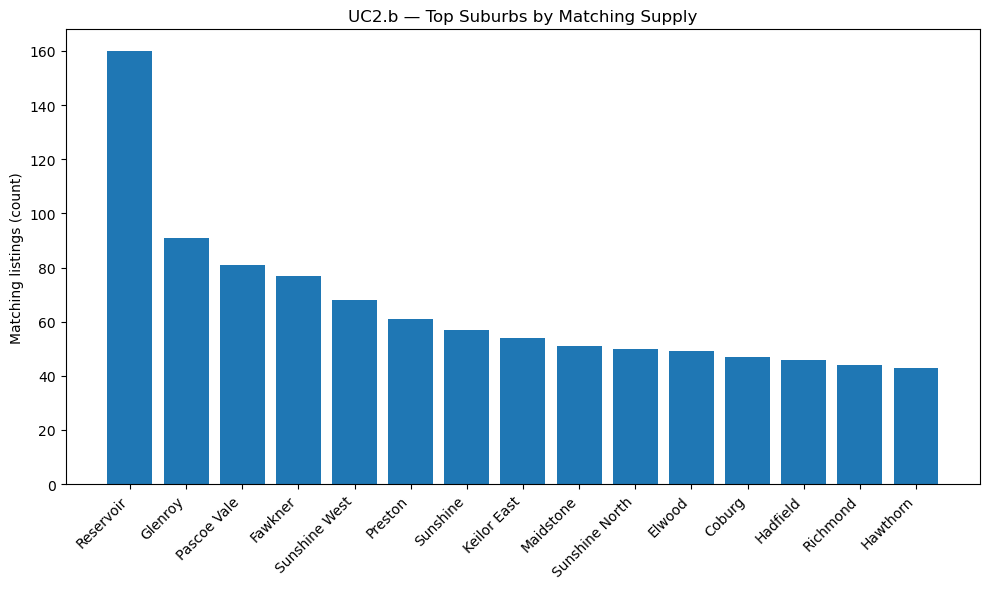

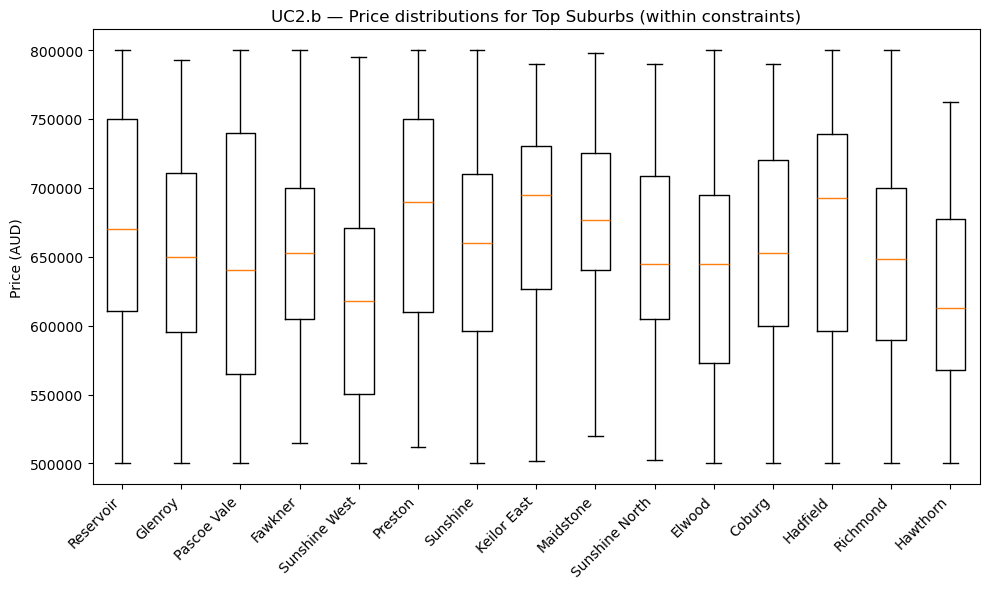

Valid rows: 13,580 | After filters: 3,708 | Stable suburbs: 45
        Suburb   median      IQR  count
     Reservoir 670000.0 139500.0    160
       Glenroy 650000.0 115250.0     91
   Pascoe Vale 640000.0 175000.0     81
       Fawkner 652500.0  95000.0     77
 Sunshine West 617500.0 120875.0     68
       Preston 690000.0 140000.0     61
      Sunshine 660000.0 114001.0     57
   Keilor East 695000.0 104000.0     54
     Maidstone 676500.0  85250.0     51
Sunshine North 645000.0 103750.0     50
        Elwood 645000.0 122500.0     49
        Coburg 653000.0 120500.0     47
      Hadfield 692750.0 142375.0     46
      Richmond 648000.0 110500.0     44
      Hawthorn 612500.0 110000.0     43


In [97]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb","Suburb")
PRICE  = cols.get("price","Price")
TYPE   = cols.get("type","Type")
ROOMS  = cols.get("rooms","Rooms")
CAR    = cols.get("car","Car")
BA     = cols.get("buildingarea","BuildingArea")
LS     = cols.get("landsize","Landsize")


df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
if ROOMS in df.columns: df[ROOMS] = pd.to_numeric(df[ROOMS], errors="coerce")
if CAR   in df.columns: df[CAR]   = pd.to_numeric(df[CAR], errors="coerce")
if BA    in df.columns: df[BA]    = pd.to_numeric(df[BA], errors="coerce")
if LS    in df.columns: df[LS]    = pd.to_numeric(df[LS], errors="coerce")

BUDGET_MIN, BUDGET_MAX = 500_000, 800_000  
ALLOWED_TYPES = {"h","t","u"}             
ROOMS_MIN, ROOMS_MAX = 2, None             
CAR_MIN = 1                                 
BA_MIN, BA_MAX = None, None                 
LS_MIN, LS_MAX = None, None                 

SUBURB_MIN_COUNT = 25
TOP_K = 15


d = df.copy()
d = d[(pd.to_numeric(d[PRICE], errors="coerce") > 0) & d[SUBURB].notna()]
d = d[(d[PRICE] >= BUDGET_MIN) & (d[PRICE] <= BUDGET_MAX)]

if ALLOWED_TYPES and TYPE in d.columns:
    d = d[d[TYPE].astype(str).str.lower().isin({t.lower() for t in ALLOWED_TYPES})]
if ROOMS in d.columns and ROOMS_MIN is not None:
    d = d[d[ROOMS] >= ROOMS_MIN]
if ROOMS in d.columns and ROOMS_MAX is not None:
    d = d[d[ROOMS] <= ROOMS_MAX]
if CAR in d.columns and CAR_MIN is not None:
    d = d[d[CAR] >= CAR_MIN]
if BA in d.columns:
    if BA_MIN is not None: d = d[d[BA] >= BA_MIN]
    if BA_MAX is not None: d = d[d[BA] <= BA_MAX]
if LS in d.columns:
    if LS_MIN is not None: d = d[d[LS] >= LS_MIN]
    if LS_MAX is not None: d = d[d[LS] <= LS_MAX]

g = (
    d.groupby(SUBURB)[PRICE]
      .agg(median="median",
           q1=lambda s: s.quantile(0.25),
           q3=lambda s: s.quantile(0.75),
           count="size")
      .reset_index()
      .rename(columns={SUBURB:"Suburb"})
)
g["IQR"] = g["q3"] - g["q1"]
g_stable = g[g["count"] >= SUBURB_MIN_COUNT].sort_values(["count","median"], ascending=[False, True])

top = g_stable.head(TOP_K).copy()

plt.figure(figsize=(10, 6))
plt.bar(top["Suburb"], top["count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Matching listings (count)")
plt.title("UC2.b — Top Suburbs by Matching Supply")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
box_data = [d.loc[d[SUBURB]==s, PRICE].dropna().values for s in top["Suburb"]]
plt.boxplot(box_data, showfliers=False)         
plt.xticks(range(1, len(top) + 1),               
           top["Suburb"].tolist(),
           rotation=45, ha="right")
plt.ylabel("Price (AUD)")
plt.title("UC2.b — Price distributions for Top Suburbs (within constraints)")
plt.tight_layout()
plt.show()

print(f"Valid rows: {len(df[(df[PRICE]>0) & df[SUBURB].notna()]):,} | "
      f"After filters: {len(d):,} | Stable suburbs: {len(g_stable)}")
print(top[["Suburb","median","IQR","count"]].to_string(index=False))

In [203]:
report='''
After filtering, approximately 3,701 properties met the criteria; 45 areas had a sufficient number of listings (≥25 properties) for analysis. 
The areas with the highest concentration of listings were Reservoir, Glenroy, Pascoe, Fawkner, and SunshineWest, as shown in the bar chart. 
The median price in these popular areas ranged from approximately AUD 610,000 to 700,000, 
with an interquartile range (IQR) of approximately AUD 95000 to 170000. 
This indicates that property prices are relatively concentrated, which can help buyers develop a negotiation strategy. 
Buyers looking for more options within their budget should consider prioritizing these areas: Reservoir, Glenroy, Sunshine, Epping, and Frankston.
'''
print(report)


After filtering, approximately 3,701 properties met the criteria; 45 areas had a sufficient number of listings (≥25 properties) for analysis. 
The areas with the highest concentration of listings were Reservoir, Glenroy, Pascoe, Fawkner, and SunshineWest, as shown in the bar chart. 
The median price in these popular areas ranged from approximately AUD 610,000 to 700,000, 
with an interquartile range (IQR) of approximately AUD 95000 to 170000. 
This indicates that property prices are relatively concentrated, which can help buyers develop a negotiation strategy. 
Buyers looking for more options within their budget should consider prioritizing these areas: Reservoir, Glenroy, Sunshine, Epping, and Frankston.



In [204]:
report='''
UC2.c — Method mix by market
Question: Where and when are auctions most effective?
'''
print(report)


UC2.c — Method mix by market
Question: Where and when are auctions most effective?



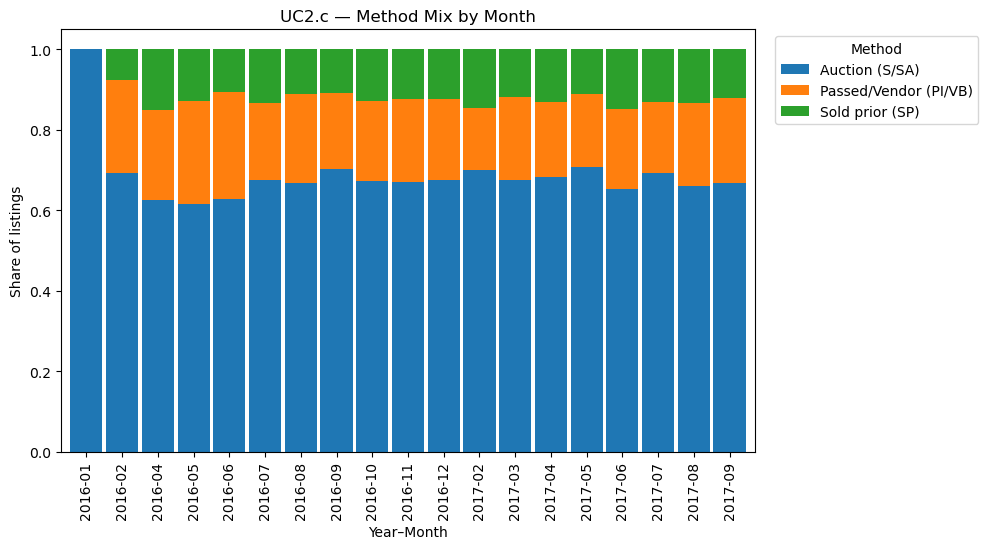

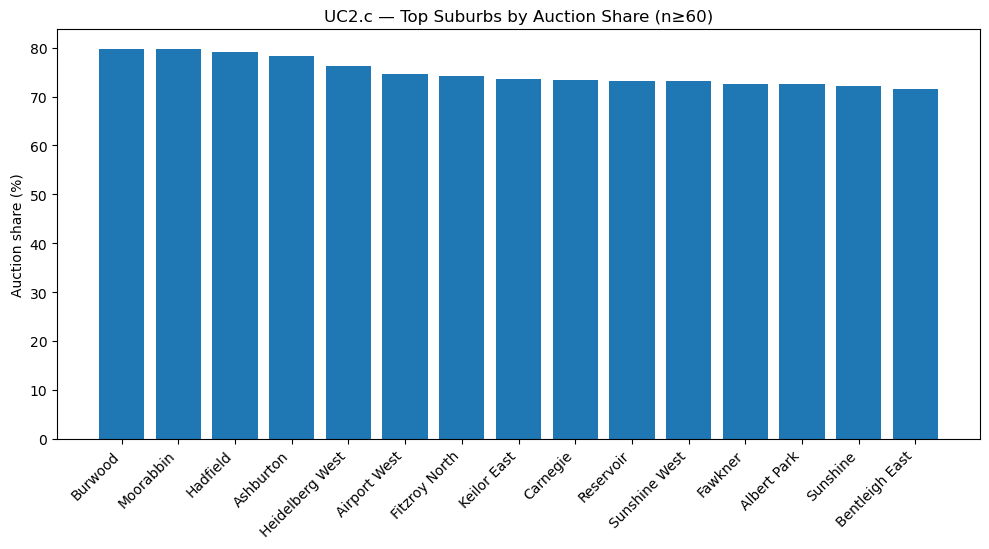

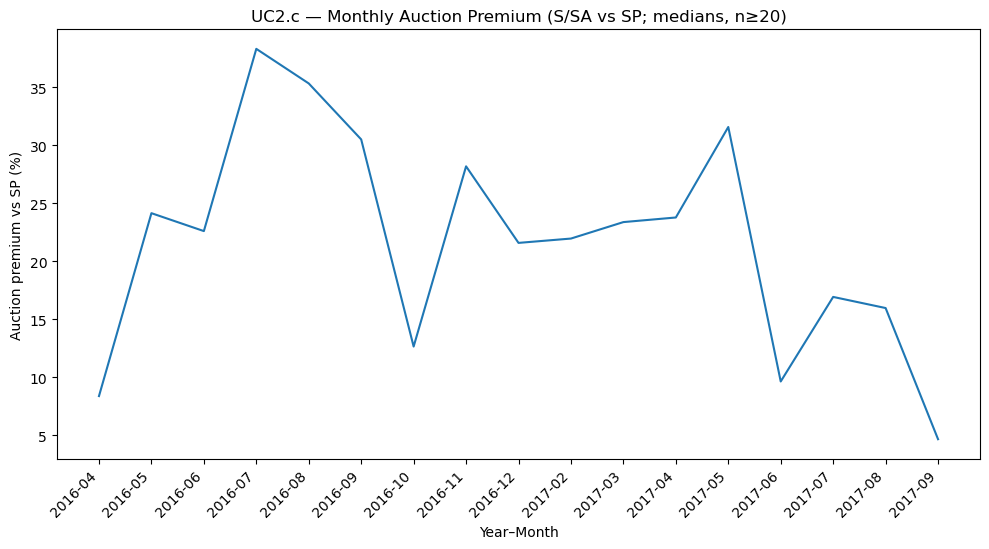

In [206]:
cols = {c.lower(): c for c in df.columns}
SUBURB = cols.get("suburb","Suburb")
PRICE  = cols.get("price","Price")
DATE   = cols.get("date","Date")
METHOD = cols.get("method","Method")
TYPE   = cols.get("type","Type")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
df[DATE]  = pd.to_datetime(df[DATE], errors="coerce", dayfirst=True)
if TYPE in df.columns: df[TYPE] = df[TYPE].astype(str).str.lower()

d = df[(df[PRICE] > 0) & df[DATE].notna() & df[METHOD].notna()].copy()
d["year_month"] = d[DATE].dt.to_period("M").astype(str)


def method_bucket(m):
    m = str(m).strip().upper()
    if m in {"S","SA"}: return "Auction (S/SA)"
    if m == "SP":      return "Sold prior (SP)"
    if m in {"PI","VB"}: return "Passed/Vendor (PI/VB)"
    return "Other"
d["MethodBucket"] = d[METHOD].apply(method_bucket)


mix = d.groupby(["year_month","MethodBucket"]).size().reset_index(name="n")
mix["share"] = mix["n"] / mix.groupby("year_month")["n"].transform("sum")
mix_piv = mix.pivot(index="year_month", columns="MethodBucket", values="share").fillna(0).sort_index()

plt.figure(figsize=(10,5.6))
mix_piv.plot(kind="bar", stacked=True, ax=plt.gca(), width=0.9)
plt.title("UC2.c — Method Mix by Month")
plt.ylabel("Share of listings"); plt.xlabel("Year–Month")
plt.legend(title="Method", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()


sub = d.groupby([SUBURB,"MethodBucket"]).size().reset_index(name="n")
sub["total_n"] = sub.groupby(SUBURB)["n"].transform("sum")
sub["share"]   = sub["n"] / sub["total_n"]
auction_share = sub[sub["MethodBucket"]=="Auction (S/SA)"].copy()
MIN_SUB_N = 60
top_sub = (auction_share[auction_share["total_n"]>=MIN_SUB_N]
           .sort_values(["share","total_n"], ascending=[False,False]).head(15))

plt.figure(figsize=(10,5.6))
plt.bar(top_sub[SUBURB], top_sub["share"]*100)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Auction share (%)")
plt.title(f"UC2.c — Top Suburbs by Auction Share (n≥{MIN_SUB_N})")
plt.tight_layout(); plt.show()


rows = []
for ym, grp in d.groupby("year_month"):
    a = grp[grp["MethodBucket"]=="Auction (S/SA)"][PRICE].dropna()
    p = grp[grp["MethodBucket"]=="Sold prior (SP)"][PRICE].dropna()
    if len(a)>=20 and len(p)>=20:
        prem = a.median() - p.median()
        prem_pct = prem / p.median() * 100
        rows.append({"year_month": ym, "prem_pct": prem_pct,
                     "n_auction": len(a), "n_prior": len(p)})
prem = pd.DataFrame(rows).sort_values("year_month")

if not prem.empty:
    plt.figure(figsize=(10,5.6))
    plt.plot(prem["year_month"], prem["prem_pct"])
    plt.ylabel("Auction premium vs SP (%)")
    plt.xlabel("Year–Month")
    plt.title("UC2.c — Monthly Auction Premium (S/SA vs SP; medians, n≥20)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

In [207]:
report='''
Auction methods (S/SA) dominate most months, accounting for nearly 2/3 of sales; SP (private treaty) has the smallest share, 
while PI/VB fluctuates with market activity. Auction rates are typically higher during peak seasons (spring/early year).

In several suburbs, the auction rate is ≥70%, as shown in the top-ranked suburbs in your chart (those labeled on the right side of the bar chart). 
In these areas, auctions are the dominant sales method: sellers can more easily attract buyers and generate competitive bidding; 
buyers need to prepare their bidding budget and strategy in advance.

Comparing the monthly median price differences between S/SA and SP, a positive "auction premium" often appears; 
in some months, the difference is insignificant. Note that this is a market-level comparison, without controlling for location/property type/size, 
and therefore should not be used as a rule for individual property valuation.
'''
print(report)


Auction methods (S/SA) dominate most months, accounting for nearly 2/3 of sales; SP (private treaty) has the smallest share, 
while PI/VB fluctuates with market activity. Auction rates are typically higher during peak seasons (spring/early year).

In several suburbs, the auction rate is ≥70%, as shown in the top-ranked suburbs in your chart (those labeled on the right side of the bar chart). 
In these areas, auctions are the dominant sales method: sellers can more easily attract buyers and generate competitive bidding; 
buyers need to prepare their bidding budget and strategy in advance.

Comparing the monthly median price differences between S/SA and SP, a positive "auction premium" often appears; 
in some months, the difference is insignificant. Note that this is a market-level comparison, without controlling for location/property type/size, 
and therefore should not be used as a rule for individual property valuation.



In [208]:
report='''
UC2.d — Affordability & Targeting (price bands)
Question: How to segment markets by affordability?
'''
print(report)


UC2.d — Affordability & Targeting (price bands)
Question: How to segment markets by affordability?




Price band thresholds (quantile-based):
     Band     Lower     Upper
 Very Low       NaN  600000.0
      Low  600000.0  800000.0
   Medium  800000.0 1040000.0
     High 1040000.0 1450000.0
Very High 1450000.0       NaN


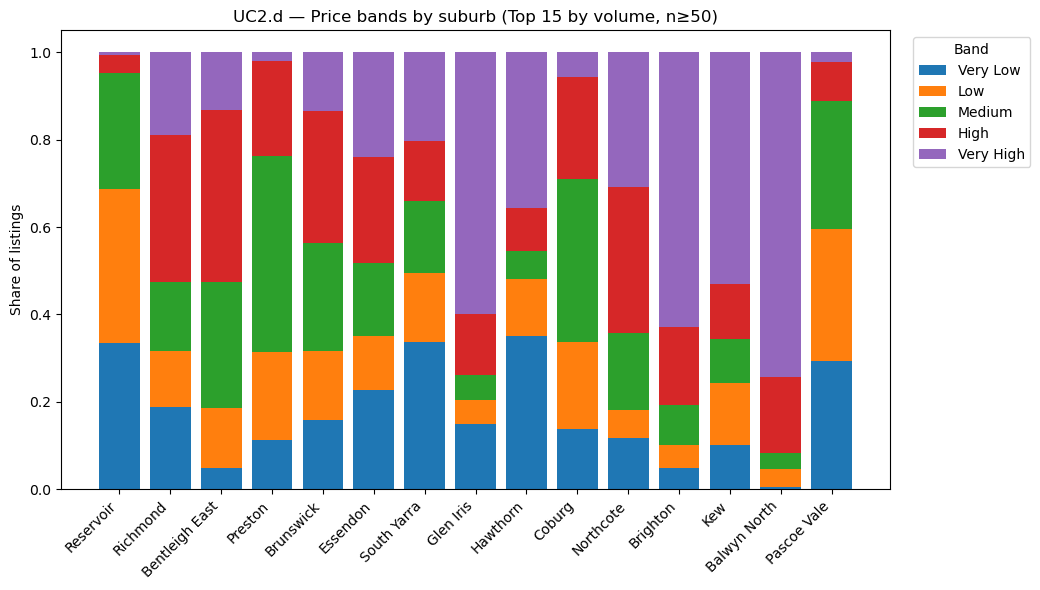

In [214]:
cols   = {c.lower(): c for c in df.columns}
PRICE  = cols.get("price","Price")
SUBURB = cols.get("suburb","Suburb")
TYPE   = cols.get("type","Type")

df[PRICE] = pd.to_numeric(df[PRICE], errors="coerce")
d = df[(df[PRICE] > 0) & df[SUBURB].notna()].copy()
if TYPE in d.columns:
    d = d[d[TYPE].astype(str).str.lower().isin({"h","t","u"})]  


qs     = d[PRICE].quantile([0.2,0.4,0.6,0.8]).to_list()
edges  = [-np.inf] + qs + [np.inf]
labels = ["Very Low","Low","Medium","High","Very High"]
d["Band"] = pd.cut(d[PRICE], bins=edges, labels=labels, include_lowest=True)

thr = pd.DataFrame({"Band": labels,
                    "Lower": [edges[i] for i in range(len(edges)-1)],
                    "Upper": [edges[i+1] for i in range(len(edges)-1)]})
thr_print = thr.copy()
thr_print["Lower"] = thr_print["Lower"].replace([-np.inf], np.nan).round(0)
thr_print["Upper"] = thr_print["Upper"].replace([np.inf],  np.nan).round(0)
print("\nPrice band thresholds (quantile-based):")
print(thr_print.to_string(index=False))


MIN_N = 50  

g = d.groupby([SUBURB, "Band"], observed=True).size().reset_index(name="n")
tot = g.groupby(SUBURB, observed=True)["n"].transform("sum")
g["share"] = g["n"] / tot


stable_n = tot.groupby(g[SUBURB], observed=True).max()
stable_suburbs = stable_n[stable_n >= MIN_N].index
g_stable = g[g[SUBURB].isin(stable_suburbs)].copy()

# Top suburbs by volume
top_suburbs = (g_stable.groupby(SUBURB, observed=True)["n"].sum()
               .sort_values(ascending=False).head(15).index.tolist())


share_wide = (g_stable.pivot_table(index=SUBURB, columns="Band",
                                   values="share", aggfunc="sum", observed=True)
              .reindex(columns=labels).fillna(0))
share_top = share_wide.loc[top_suburbs]


plt.figure(figsize=(10.5, 6))
x = np.arange(len(share_top))
bottom = np.zeros(len(share_top))
for lab in labels:
    vals = share_top[lab].values
    plt.bar(x, vals, bottom=bottom, label=lab)
    bottom += vals
plt.xticks(x, share_top.index, rotation=45, ha="right")
plt.ylabel("Share of listings")
plt.title(f"UC2.d — Price bands by suburb (Top {len(share_top)} by volume, n≥{MIN_N})")
plt.legend(title="Band", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.show()

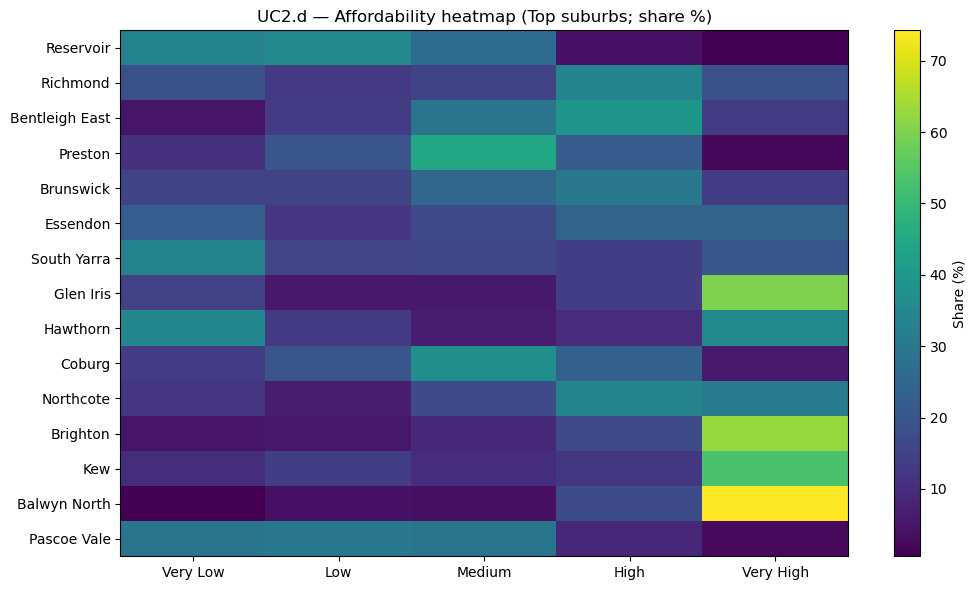

In [215]:
plt.figure(figsize=(10.5, 6))
mat = (share_top * 100).values
im = plt.imshow(mat, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Share (%)")
plt.yticks(np.arange(len(share_top.index)), share_top.index)
plt.xticks(np.arange(len(labels)), labels)
plt.title("UC2.d — Affordability heatmap (Top suburbs; share %)")
plt.tight_layout(); plt.show()

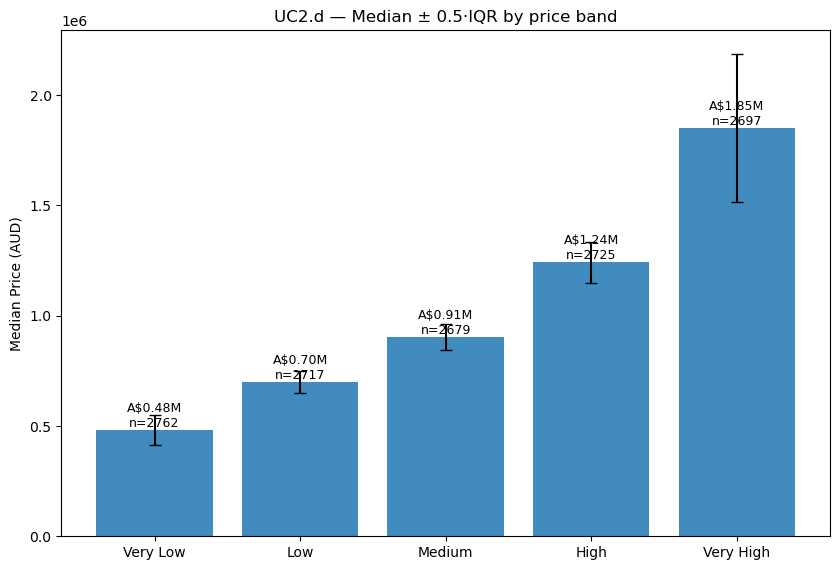

In [216]:
band_stats = (d.groupby("Band", observed=True)[PRICE]
                .agg(median="median",
                     q1=lambda s: s.quantile(0.25),
                     q3=lambda s: s.quantile(0.75),
                     count="size")
                .reindex(labels).reset_index())
band_stats["IQR"] = band_stats["q3"] - band_stats["q1"]

plt.figure(figsize=(8.5, 5.8))
xb = np.arange(len(labels))
plt.bar(xb, band_stats["median"], yerr=band_stats["IQR"]/2, capsize=4, alpha=0.85)
plt.xticks(xb, labels)
plt.ylabel("Median Price (AUD)")
plt.title("UC2.d — Median ± 0.5·IQR by price band")
for i, y in enumerate(band_stats["median"]):
    plt.text(i, y, f"A${y/1_000_000:.2f}M\nn={int(band_stats.loc[i,'count'])}",
             ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()


In [217]:
low_focus  = (g_stable[g_stable["Band"]=="Very Low"]
              .sort_values("share", ascending=False)
              .head(10)[[SUBURB, "share", "n"]]
              .assign(**{"share(%)": lambda x: (x["share"]*100).round(1)}))
high_focus = (g_stable[g_stable["Band"]=="Very High"]
              .sort_values("share", ascending=False)
              .head(10)[[SUBURB, "share", "n"]]
              .assign(**{"share(%)": lambda x: (x["share"]*100).round(1)}))

print("\nTop suburbs by Very Low share:")
print(low_focus[[SUBURB, "share(%)", "n"]].to_string(index=False))

print("\nTop suburbs by Very High share:")
print(high_focus[[SUBURB, "share(%)", "n"]].to_string(index=False))


Top suburbs by Very Low share:
         Suburb  share(%)  n
       Werribee      80.0 40
         Epping      67.3 35
       St Kilda      55.6 90
  Sunshine West      52.3 45
Heidelberg West      40.8 31
        Windsor      38.3 23
    Maribyrnong      37.5 36
North Melbourne      37.0 30
        Glenroy      36.5 58
      Footscray      36.4 48

Top suburbs by Very High share:
      Suburb  share(%)   n
 Albert Park      76.8  53
   Ashburton      75.0  45
Balwyn North      74.3 127
  Canterbury      70.4  38
      Balwyn      64.5  69
    Brighton      62.9 117
     Hampton      60.8  79
   Glen Iris      60.0 117
  Camberwell      59.1  78
Surrey Hills      58.4  73


In [220]:
report='''
Based on this data (n=13,580), prices were categorized into five bands using quantiles: 
Very Low (<A$600k), Low (A$600k–800k), Medium (A$800k–1.04M), High (A$1.04M–1.45M), and Very High (≥A$1.45M).

The corresponding median prices and interquartile ranges (IQR) were approximately A$482.8k (IQR≈A$138.9k), A$700.0k (≈A$100.0k),
A$905.0k (≈A$118.0k), A$1.242M (≈A$186.0k), and A$1.85M (≈A$670.0k).Higher price bands exhibit greater price volatility and heterogeneity. 

The distribution across the five bands is relatively even (approximately 20% ± 1%: Very Low 20.3%, Low 20.0%, Medium 19.7%, High 20.1%, Very High 19.9%),
but suburban differences are significant: 
Entry-level/affordable areas are represented by Werribee (80.0% Very Low), Epping (67.3%), St Kilda (55.6%), Sunshine West (52.3%), 
and Heidelberg West (40.8%), while premium areas are represented by 
Albert Park (76.8% Very High), Ashburton (75.0%), Balwyn North (74.3%), Canterbury (70.4%), and Balwyn (64.5%).  

In practice, buyers should first identify their price range and prioritize suburbs with a high market share and a narrow IQR within that range. 
Sellers should target their marketing and supply to the corresponding "dominant price band" suburbs.
'''
print(report)


Based on this data (n=13,580), prices were categorized into five bands using quantiles: 
Very Low (<A$600k), Low (A$600k–800k), Medium (A$800k–1.04M), High (A$1.04M–1.45M), and Very High (≥A$1.45M).

The corresponding median prices and interquartile ranges (IQR) were approximately A$482.8k (IQR≈A$138.9k), A$700.0k (≈A$100.0k),
A$905.0k (≈A$118.0k), A$1.242M (≈A$186.0k), and A$1.85M (≈A$670.0k).Higher price bands exhibit greater price volatility and heterogeneity. 

The distribution across the five bands is relatively even (approximately 20% ± 1%: Very Low 20.3%, Low 20.0%, Medium 19.7%, High 20.1%, Very High 19.9%),
but suburban differences are significant: 
Entry-level/affordable areas are represented by Werribee (80.0% Very Low), Epping (67.3%), St Kilda (55.6%), Sunshine West (52.3%), 
and Heidelberg West (40.8%), while premium areas are represented by 
Albert Park (76.8% Very High), Ashburton (75.0%), Balwyn North (74.3%), Canterbury (70.4%), and Balwyn (64.5%).  

In practice, bu